# BFSI Credit Risk Assessment - LGD Computation

Expected credit loss (ECL) computation is a method used in credit risk management to determine the amount of loss a bank is expected to incur in the event a borrower defaults on their loan. Different banks may use different methodologies for calculating the expected credit loss (ECL) and provisioning of a bank. Banks are allowed to use their own methodologies and incorporate factors relevant to their specific business operations.

The formula for ECL typically used in practice is as follows:

ECL = EAD x PD x LGD

Expected credit loss = Exposure at default x Probability of Default x Loss given default

ECLs are calculated based on the exposure at default (EAD), probability of default (PD) and the loss given default (LGD) for each borrower. Banks can calculate the ECL for different points in time based on their risk management strategy and regulatory requirements.

**What is LGD?**


The loss given default (LGD) is a measure of the amount of loss that a bank is expected to incur in the event of a default by a borrower. In a dataset containing the historical data of loans defaulted, such as the value of the collateral (if any), loan tenure, number of missed repayments, etc. the bank tries to estimate the approximate amount that it stands to lose if a borrower defaults. It might seem evident that this can be directly calculated by subtracting the collateral amount and the repayments received against the loan from the present outstanding loan amount. However, banks make collection efforts even after a borrower has defaulted. Therefore, the LGD is estimated using historical data from the default loan base using statistical methods. 


For this assignment, we will focus only on **Loss Given Default** component of ECL computation. 

**Objective: To build statistical model to estimate LGD of borrower for defaulted accounts.**

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

To achieve the objective of case study, we will consider the latest date from which the data is available as the point in time. This means we estimate LGD  the for the borrower assuming that the borrower has defaulted at the present point in time.

# Data Cleaning and Preparation for Main Dataset

# 1. Main Loan Dataset

In [3]:
# Let's have a look at main loan dataset
loan = pd.read_csv("main_loan_base.csv")
loan.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,disbursal_date,default_date
0,LN79307711,Aarna Sura,"09/506, Anand Path, Ongole 646592",Consumer-Durable,21916,4929.47,3,0,3,127,2,10.1,1012.32,2019-04-14,2020-07-31
1,LN88987787,Amira Konda,"11, Dhaliwal Circle\nRaichur 659460",Two-Wheeler,121184,10254.50,1,0,0,156,2,11.8,5693.24,2015-04-14,2016-07-30
2,LN78096023,Eshani Khosla,H.No. 31\nAtwal Street\nKatihar-037896,Car,487036,116183.86,0,1,10,22,3,14.6,16788.02,2015-01-10,2015-04-18
3,LN56862431,Divij Kala,"766, Gulati Marg\nPudukkottai-051396",Two-Wheeler,52125,10310.05,5,2,9,30,2,9.6,2395.69,2018-02-07,2018-09-13
4,LN77262680,Vaibhav Bir,"55/73, Sachdev Marg\nDharmavaram-332966",Consumer-Durable,8635,1051.25,0,1,3,62,2,9.6,396.87,2014-12-25,2016-02-20


In [4]:
# Meta data check for main loan dataset
print("The dimention of loan dataset is: ",loan.shape)
print("-----------------------------------------------")
print("Check for null values: ", loan.info())
print("-----------------------------------------------")
print("Count of unique loan account numbers: ",loan['loan_acc_num'].nunique())

The dimention of loan dataset is:  (50000, 15)
-----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan_acc_num       50000 non-null  object 
 1   customer_name      50000 non-null  object 
 2   customer_address   50000 non-null  object 
 3   loan_type          50000 non-null  object 
 4   loan_amount        50000 non-null  int64  
 5   collateral_value   50000 non-null  float64
 6   cheque_bounces     50000 non-null  int64  
 7   number_of_loans    50000 non-null  int64  
 8   missed_repayments  50000 non-null  int64  
 9   vintage_in_months  50000 non-null  int64  
 10  tenure_years       50000 non-null  int64  
 11  interest           50000 non-null  float64
 12  monthly_emi        50000 non-null  float64
 13  disbursal_date     50000 non-null  object 
 14  default_date       5000

**Observations**:
1. There are no null values.  
2. Data type of date columns needs to be changed. 
3. some banks might calculate the parameters at an account level, whereby it treats each loan as a separate entity, independent of the other loans that the borrower might have taken. 
4. In this assignment, we will use the account level method and treat every loan separately. There are **15** duplicate loan account numbers. As the loan account number is unique for each customer we can drop the duplicates. 

In [5]:
# Changing data type
loan['default_date'] = pd.to_datetime(loan['default_date'])
loan['disbursal_date'] = pd.to_datetime(loan['disbursal_date'])

In [6]:
# Creating a new data set with zero duplicates.
df1 = loan[~loan['loan_acc_num'].duplicated()]
print(df1.shape)

(49985, 15)


# 2. Repayment Dataset

In [7]:
# Reading the file
repayment = pd.read_csv("repayment_base.csv")
repayment.head()

,loan_acc_num,repayment_amount,repayment_date
0,LN79307711,1012.320000,2019-05-18
1,LN79307711,667.987539,2019-06-20
2,LN79307711,1012.320000,2019-07-16
3,LN79307711,1012.320000,2019-08-16
4,LN79307711,1012.320000,2019-09-22


In [8]:
# Metadata check for repayment dataset
print("The dimention of repayment dataset is: ",repayment.shape)
print("-------------------------------------------------------")
print("Check for null values: ",repayment.info())
print("-------------------------------------------------------")
print("Count of unique loan account numbers: ", repayment['loan_acc_num'].nunique())

The dimention of repayment dataset is:  (626601, 3)
-------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626601 entries, 0 to 626600
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_acc_num      626601 non-null  object 
 1   repayment_amount  626601 non-null  float64
 2   repayment_date    626601 non-null  object 
dtypes: float64(1), object(2)
memory usage: 14.3+ MB
Check for null values:  None
-------------------------------------------------------
Count of unique loan account numbers:  46008


**Observation**:

1. As it is a repayment dataset we can see several entries for single account number corresponding to it's date of repayment. 
2. A new column can be derived as total repaid amount which will be sum of all repayments done till date. 
3. Applying formala to aggregate repaid values as **repayment_amount = SUM of all repayment amounts for each unique loan account number.**

In [9]:
# Taking aggregate of repaid amount
repayment_sum = round(repayment.groupby('loan_acc_num')['repayment_amount'].sum(),2)
df2 = pd.DataFrame({"loan_acc_num":repayment_sum.index, "repayment_amount":repayment_sum.values})
df2.head()

,loan_acc_num,repayment_amount
0,LN10000701,40020.99
1,LN10001077,112218.47
2,LN10004116,290634.94
3,LN10007976,337321.72
4,LN10010204,61290.49


In [10]:
df2.shape

(46008, 2)

# Merging loan and repayment datsets

In [11]:
# Merging repayment data with main loan base data.
merge1 = pd.merge(df1,df2, on='loan_acc_num', how='left')
merge1.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,disbursal_date,default_date,repayment_amount
0,LN79307711,Aarna Sura,"09/506, Anand Path, Ongole 646592",Consumer-Durable,21916,4929.47,3,0,3,127,2,10.1,1012.32,2019-04-14,2020-07-31,13572.58
1,LN88987787,Amira Konda,"11, Dhaliwal Circle\nRaichur 659460",Two-Wheeler,121184,10254.50,1,0,0,156,2,11.8,5693.24,2015-04-14,2016-07-30,96243.61
2,LN78096023,Eshani Khosla,H.No. 31\nAtwal Street\nKatihar-037896,Car,487036,116183.86,0,1,10,22,3,14.6,16788.02,2015-01-10,2015-04-18,74083.73
3,LN56862431,Divij Kala,"766, Gulati Marg\nPudukkottai-051396",Two-Wheeler,52125,10310.05,5,2,9,30,2,9.6,2395.69,2018-02-07,2018-09-13,NaN
4,LN77262680,Vaibhav Bir,"55/73, Sachdev Marg\nDharmavaram-332966",Consumer-Durable,8635,1051.25,0,1,3,62,2,9.6,396.87,2014-12-25,2016-02-20,4462.51


Here, we can derive a new column as due amount as the difference of loan amount and repayment amount. This feature might be useful later for model building. 

In [12]:
merge1.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,disbursal_date,default_date,repayment_amount
0,LN79307711,Aarna Sura,"09/506, Anand Path, Ongole 646592",Consumer-Durable,21916,4929.47,3,0,3,127,2,10.1,1012.32,2019-04-14,2020-07-31,13572.58
1,LN88987787,Amira Konda,"11, Dhaliwal Circle\nRaichur 659460",Two-Wheeler,121184,10254.50,1,0,0,156,2,11.8,5693.24,2015-04-14,2016-07-30,96243.61
2,LN78096023,Eshani Khosla,H.No. 31\nAtwal Street\nKatihar-037896,Car,487036,116183.86,0,1,10,22,3,14.6,16788.02,2015-01-10,2015-04-18,74083.73
3,LN56862431,Divij Kala,"766, Gulati Marg\nPudukkottai-051396",Two-Wheeler,52125,10310.05,5,2,9,30,2,9.6,2395.69,2018-02-07,2018-09-13,NaN
4,LN77262680,Vaibhav Bir,"55/73, Sachdev Marg\nDharmavaram-332966",Consumer-Durable,8635,1051.25,0,1,3,62,2,9.6,396.87,2014-12-25,2016-02-20,4462.51


In [13]:
merge1.isnull().sum()

loan_acc_num            0
customer_name           0
customer_address        0
loan_type               0
loan_amount             0
collateral_value        0
cheque_bounces          0
number_of_loans         0
missed_repayments       0
vintage_in_months       0
tenure_years            0
interest                0
monthly_emi             0
disbursal_date          0
default_date            0
repayment_amount     3977
dtype: int64

**Observation:**
1. It is observed that, for **3977** accounts the repayment_amount value is missing. We can infer that the account holder has not paid any instalment. So we will have to replace NaN value of repayment_amount with 0. This will automatically take care of missing values for due_amount as it is derived from repayment_amount.
2. Here, we can not perform mean/mode imputation as the value repayment_amount for each account number will depend on respective loan amount, tenure, EMI and interest rate.

In [14]:
merge1['repayment_amount'] = merge1['repayment_amount'].fillna(0)

In [15]:
merge1.isnull().sum()

loan_acc_num         0
customer_name        0
customer_address     0
loan_type            0
loan_amount          0
collateral_value     0
cheque_bounces       0
number_of_loans      0
missed_repayments    0
vintage_in_months    0
tenure_years         0
interest             0
monthly_emi          0
disbursal_date       0
default_date         0
repayment_amount     0
dtype: int64

In [16]:
# Deriving new column of due amount
merge1['due_amount'] = merge1['loan_amount'] - merge1['repayment_amount']

In [17]:
merge1.isnull().sum()

loan_acc_num         0
customer_name        0
customer_address     0
loan_type            0
loan_amount          0
collateral_value     0
cheque_bounces       0
number_of_loans      0
missed_repayments    0
vintage_in_months    0
tenure_years         0
interest             0
monthly_emi          0
disbursal_date       0
default_date         0
repayment_amount     0
due_amount           0
dtype: int64

# 3. Balance DataSet

In [18]:
# Reading the file
monthly_balance = pd.read_csv("monthly_balance_base.csv")
monthly_balance.head()

,loan_acc_num,date,balance_amount
0,LN79307711,2010-03-26,407.343213
1,LN79307711,2010-04-25,545.431227
2,LN79307711,2010-05-25,861.932145
3,LN79307711,2010-06-24,562.082133
4,LN79307711,2010-07-24,37.768861


In [19]:
# Metadata check for balance data set
print("The dimention of repayment dataset is: ", monthly_balance.shape)
print("-------------------------------------------")
print("Check for null values: ",monthly_balance.info())
print("-------------------------------------------")
print("Count of unique loan account numbers: ", monthly_balance['loan_acc_num'].nunique())

The dimention of repayment dataset is:  (4002490, 3)
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4002490 entries, 0 to 4002489
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   loan_acc_num    object 
 1   date            object 
 2   balance_amount  float64
dtypes: float64(1), object(2)
memory usage: 91.6+ MB
Check for null values:  None
-------------------------------------------
Count of unique loan account numbers:  49671


In [20]:
# Changing data type of date column
monthly_balance['date']=pd.to_datetime(monthly_balance['date'])

**Observation**:
1. Monthly balance dataset contains multiple entries for single loan account number. 
2. From this we can derive a new column which will contain average monthly balance of each account number and corresponding number of entries.

In [21]:
grouped_data = monthly_balance.groupby('loan_acc_num')

In [22]:
# Derving avg_balance column
avg_balance = round(grouped_data['balance_amount'].mean(),2)

In [23]:
# Deriving no of entries column
count_entries = round(grouped_data['balance_amount'].count())

In [24]:
result_df = pd.DataFrame({'avg_balance': avg_balance, 'count_entries': count_entries})

In [25]:
result_df.head()

,avg_balance,count_entries
loan_acc_num,,
LN10000701,2301.88,20
LN10001077,2296.28,113
LN10004116,8887.38,140
LN10007976,9420.56,79
LN10010204,6446.21,15


For the modelling purpose we can derive one more column which will contain the **latest balance of account number** just before defaulting.

In [26]:
monthly_balance = monthly_balance.sort_values('date', ascending=False)

In [27]:
df3 = monthly_balance.drop_duplicates(subset=['loan_acc_num'], keep='first')

In [28]:
df3['balance_amount']= round(df3['balance_amount'],2)

In [29]:
df3.head()

,loan_acc_num,date,balance_amount
1148683,LN61439284,2026-12-25,291.17
944956,LN15312715,2026-09-08,9959.23
1807445,LN89212945,2026-09-05,3372.11
2459095,LN39452891,2026-08-11,140.56
1101239,LN37296381,2026-08-01,51.08


In [30]:
# Merging previous two datasets regarding balance amount
df4 = pd.merge(df3, result_df, on='loan_acc_num', how='left')

In [31]:
df4.head()

,loan_acc_num,date,balance_amount,avg_balance,count_entries
0,LN61439284,2026-12-25,291.17,291.56,76
1,LN15312715,2026-09-08,9959.23,9360.80,124
2,LN89212945,2026-09-05,3372.11,3257.00,120
3,LN39452891,2026-08-11,140.56,88.56,59
4,LN37296381,2026-08-01,51.08,47.68,67


In [32]:
# Renaming date column
df4.rename(columns={'date':'monthly_balance_date'}, inplace=True)

In [33]:
df4.head()

,loan_acc_num,monthly_balance_date,balance_amount,avg_balance,count_entries
0,LN61439284,2026-12-25,291.17,291.56,76
1,LN15312715,2026-09-08,9959.23,9360.80,124
2,LN89212945,2026-09-05,3372.11,3257.00,120
3,LN39452891,2026-08-11,140.56,88.56,59
4,LN37296381,2026-08-01,51.08,47.68,67


In [34]:
df4.shape

(49671, 5)

Merging all the three datasets to have a proper look for analysis

In [35]:
# Merging datasets
df = pd.merge(merge1, df4, on='loan_acc_num', how='left')
df.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,...,interest,monthly_emi,disbursal_date,default_date,repayment_amount,due_amount,monthly_balance_date,balance_amount,avg_balance,count_entries
0,LN79307711,Aarna Sura,"09/506, Anand Path, Ongole 646592",Consumer-Durable,21916,4929.47,3,0,3,127,...,10.1,1012.32,2019-04-14,2020-07-31,13572.58,8343.42,2020-06-01,780.65,585.51,125.0
1,LN88987787,Amira Konda,"11, Dhaliwal Circle\nRaichur 659460",Two-Wheeler,121184,10254.50,1,0,0,156,...,11.8,5693.24,2015-04-14,2016-07-30,96243.61,24940.39,2017-02-25,8079.19,7382.03,163.0
2,LN78096023,Eshani Khosla,H.No. 31\nAtwal Street\nKatihar-037896,Car,487036,116183.86,0,1,10,22,...,14.6,16788.02,2015-01-10,2015-04-18,74083.73,412952.27,2015-05-18,10260.63,7812.88,23.0
3,LN56862431,Divij Kala,"766, Gulati Marg\nPudukkottai-051396",Two-Wheeler,52125,10310.05,5,2,9,30,...,9.6,2395.69,2018-02-07,2018-09-13,0.00,52125.00,2018-06-15,612.53,518.08,27.0
4,LN77262680,Vaibhav Bir,"55/73, Sachdev Marg\nDharmavaram-332966",Consumer-Durable,8635,1051.25,0,1,3,62,...,9.6,396.87,2014-12-25,2016-02-20,4462.51,4172.49,2016-03-21,402.88,323.68,63.0


In [36]:
df.isnull().sum()

loan_acc_num              0
customer_name             0
customer_address          0
loan_type                 0
loan_amount               0
collateral_value          0
cheque_bounces            0
number_of_loans           0
missed_repayments         0
vintage_in_months         0
tenure_years              0
interest                  0
monthly_emi               0
disbursal_date            0
default_date              0
repayment_amount          0
due_amount                0
monthly_balance_date    314
balance_amount          314
avg_balance             314
count_entries           314
dtype: int64

**Observation:**
It is observed that, for **314** accounts, monthly balance related columns have missing values. This can be replaced with their mean/average value.

In [37]:
df['balance_amount'] = df['balance_amount'].fillna(df['balance_amount'].mean())

In [38]:
df['avg_balance'] = df['avg_balance'].fillna(df['avg_balance'].mean())

In [39]:
df['count_entries'] = df['count_entries'].fillna(df['count_entries'].mean())

In [40]:
df.isnull().sum()

loan_acc_num              0
customer_name             0
customer_address          0
loan_type                 0
loan_amount               0
collateral_value          0
cheque_bounces            0
number_of_loans           0
missed_repayments         0
vintage_in_months         0
tenure_years              0
interest                  0
monthly_emi               0
disbursal_date            0
default_date              0
repayment_amount          0
due_amount                0
monthly_balance_date    314
balance_amount            0
avg_balance               0
count_entries             0
dtype: int64

# Cleaning and Data Preperation for Test Dataset

# 1. Test Main Loan Base

In [41]:
#Test Loan dataset
test_loan =pd.read_csv("test_main_loan_base.csv")
test_loan.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,disbursal_date,default_date
0,LN14086568,Jayesh Kar,"83/65, Deo Circle\nBhagalpur-852841",Car,1259062,10184.09,3,1,5,103,1,12.1,111925.04,2014-11-23,2015-04-30
1,LN37082418,Kaira Chhabra,17\nSule Ganj\nAizawl 491897,Consumer-Durable,21731,2313.21,0,3,26,39,5,12.2,485.59,2014-01-11,2017-03-11
2,LN42963368,Anahita Bhargava,51/421\nKannan Chowk\nVaranasi-209999,Car,207660,8308.71,1,2,0,63,1,13.9,18635.42,2012-10-26,2013-06-23
3,LN54572294,Myra Samra,"22\nSubramanian Marg, Bhilai 850327",Two-Wheeler,193528,26432.24,4,3,12,15,2,12.5,9155.29,2021-10-07,2023-01-19
4,LN65792799,Arhaan Rana,"22, Kapoor Road\nJalandhar 667155",Consumer-Durable,5980,1641.66,1,1,0,152,1,14.6,538.62,2020-03-04,2020-10-08


In [42]:
# Meta data check for main loan dataset of TEST
print("The dimension of test loan dataset is: ",test_loan.shape)
print("-------------------------------------------")
print("Check for null values: ", test_loan.info())
print("-------------------------------------------")
print("Count of unique loan account numbers: ",test_loan['loan_acc_num'].nunique())

The dimension of test loan dataset is:  (10000, 15)
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan_acc_num       10000 non-null  object 
 1   customer_name      10000 non-null  object 
 2   customer_address   10000 non-null  object 
 3   loan_type          10000 non-null  object 
 4   loan_amount        10000 non-null  int64  
 5   collateral_value   10000 non-null  float64
 6   cheque_bounces     10000 non-null  int64  
 7   number_of_loans    10000 non-null  int64  
 8   missed_repayments  10000 non-null  int64  
 9   vintage_in_months  10000 non-null  int64  
 10  tenure_years       10000 non-null  int64  
 11  interest           10000 non-null  float64
 12  monthly_emi        10000 non-null  float64
 13  disbursal_date     10000 non-null  object 
 14  default_date       1000

**Observations**:
1. There are no null values.  
2. Data type of date columns needs to be changed. 
3. some banks might calculate the parameters at an account level, whereby it treats each loan as a separate entity, independent of the other loans that the borrower might have taken. 
4. In this assignment, we will use the account level method and treat every loan separately. There are **3** duplicate loan account numbers. As the loan account number is unique for each customer we can drop the duplicates. 

In [43]:
#Changing data type
test_loan['default_date'] = pd.to_datetime(test_loan['default_date'])
test_loan['disbursal_date'] = pd.to_datetime(test_loan['disbursal_date'])

In [44]:
test_df1 = test_loan[~test_loan['loan_acc_num'].duplicated()]
print(test_df1.shape)

(9997, 15)


# 2. Test Repayment Data

In [45]:
test_repayment = pd.read_csv("test_repayment_base.csv")
test_repayment.head()

,loan_acc_num,repayment_amount,repayment_date
0,LN14086568,111925.040000,2014-12-19
1,LN14086568,111925.040000,2015-01-26
2,LN14086568,111925.040000,2015-02-21
3,LN14086568,111925.040000,2015-03-20
4,LN14086568,11590.317813,2015-04-26


In [46]:
print("The dimension of test repayment dataset is: ",test_repayment.shape)
print("-------------------------------------------")
print("Check for null values: ",test_repayment.info())
print("-------------------------------------------")
print("Count of unique loan account numbers: ", test_repayment['loan_acc_num'].nunique())

The dimension of test repayment dataset is:  (125860, 3)
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125860 entries, 0 to 125859
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_acc_num      125860 non-null  object 
 1   repayment_amount  125860 non-null  float64
 2   repayment_date    125860 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.9+ MB
Check for null values:  None
-------------------------------------------
Count of unique loan account numbers:  9229


**Observation**:

1. As it is a repayment dataset we can see several entries for single account number corresponding to it's date of repayment. 
2. A new column can be derived as total repaid amount which will be sum of all repayments done till date. 
3. Applying formala to aggregate repaid values as **repayment_amount = SUM of all repayment amounts for each unique loan account number.**

In [47]:
test_repayment_sum = round(test_repayment.groupby('loan_acc_num')['repayment_amount'].sum(),2)
test_df2 = pd.DataFrame({"loan_acc_num":test_repayment_sum.index, "repayment_amount":test_repayment_sum.values})
test_df2.head()

,loan_acc_num,repayment_amount
0,LN10011015,1725.31
1,LN10028091,3560.31
2,LN10033713,11582.17
3,LN10045654,66181.74
4,LN10051605,87664.41


In [48]:
test_df2.shape

(9229, 2)

# Merging loan and repayment test datsets

In [49]:
merge_test1 = pd.merge(test_df1,test_df2, on='loan_acc_num', how='left')
merge_test1.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,disbursal_date,default_date,repayment_amount
0,LN14086568,Jayesh Kar,"83/65, Deo Circle\nBhagalpur-852841",Car,1259062,10184.09,3,1,5,103,1,12.1,111925.04,2014-11-23,2015-04-30,675861.05
1,LN37082418,Kaira Chhabra,17\nSule Ganj\nAizawl 491897,Consumer-Durable,21731,2313.21,0,3,26,39,5,12.2,485.59,2014-01-11,2017-03-11,2208.65
2,LN42963368,Anahita Bhargava,51/421\nKannan Chowk\nVaranasi-209999,Car,207660,8308.71,1,2,0,63,1,13.9,18635.42,2012-10-26,2013-06-23,111812.52
3,LN54572294,Myra Samra,"22\nSubramanian Marg, Bhilai 850327",Two-Wheeler,193528,26432.24,4,3,12,15,2,12.5,9155.29,2021-10-07,2023-01-19,18310.58
4,LN65792799,Arhaan Rana,"22, Kapoor Road\nJalandhar 667155",Consumer-Durable,5980,1641.66,1,1,0,152,1,14.6,538.62,2020-03-04,2020-10-08,3428.64


In [50]:
merge_test1.isnull().sum()

loan_acc_num           0
customer_name          0
customer_address       0
loan_type              0
loan_amount            0
collateral_value       0
cheque_bounces         0
number_of_loans        0
missed_repayments      0
vintage_in_months      0
tenure_years           0
interest               0
monthly_emi            0
disbursal_date         0
default_date           0
repayment_amount     768
dtype: int64

**Observation:**
1. It is observed that, for **768** accounts the repayment_amount value is missing. We can infer that the account holder has not paid any instalment. So we will have to replace NaN value of repayment_amount with 0. This will automatically take care of missing values for due_amount as it is derived from repayment_amount.
2. Here, we can not perform mean/mode imputation as the value repayment_amount for each account number will depend on respective loan amount, tenure, EMI and interest rate.

In [51]:
merge_test1['repayment_amount'] = merge_test1['repayment_amount'].fillna(0)

Here, we can derive a new column as due amount as the difference of loan amount and repayment amount. This feature might be useful later. 

In [52]:
merge_test1['due_amount'] = merge_test1['loan_amount'] - merge_test1['repayment_amount']

In [53]:
merge_test1.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,disbursal_date,default_date,repayment_amount,due_amount
0,LN14086568,Jayesh Kar,"83/65, Deo Circle\nBhagalpur-852841",Car,1259062,10184.09,3,1,5,103,1,12.1,111925.04,2014-11-23,2015-04-30,675861.05,583200.95
1,LN37082418,Kaira Chhabra,17\nSule Ganj\nAizawl 491897,Consumer-Durable,21731,2313.21,0,3,26,39,5,12.2,485.59,2014-01-11,2017-03-11,2208.65,19522.35
2,LN42963368,Anahita Bhargava,51/421\nKannan Chowk\nVaranasi-209999,Car,207660,8308.71,1,2,0,63,1,13.9,18635.42,2012-10-26,2013-06-23,111812.52,95847.48
3,LN54572294,Myra Samra,"22\nSubramanian Marg, Bhilai 850327",Two-Wheeler,193528,26432.24,4,3,12,15,2,12.5,9155.29,2021-10-07,2023-01-19,18310.58,175217.42
4,LN65792799,Arhaan Rana,"22, Kapoor Road\nJalandhar 667155",Consumer-Durable,5980,1641.66,1,1,0,152,1,14.6,538.62,2020-03-04,2020-10-08,3428.64,2551.36


In [54]:
merge_test1.isnull().sum()

loan_acc_num         0
customer_name        0
customer_address     0
loan_type            0
loan_amount          0
collateral_value     0
cheque_bounces       0
number_of_loans      0
missed_repayments    0
vintage_in_months    0
tenure_years         0
interest             0
monthly_emi          0
disbursal_date       0
default_date         0
repayment_amount     0
due_amount           0
dtype: int64

In [55]:
merge_test1.shape

(9997, 17)

# 3. Test Monthly Balance Dataset

In [56]:
test_monthly_balance = pd.read_csv("test_monthly_balance_base.csv")
test_monthly_balance.head()

,loan_acc_num,date,balance_amount
0,LN14086568,2006-12-13,9014.212689
1,LN14086568,2007-01-12,28129.516540
2,LN14086568,2007-02-11,10820.366663
3,LN14086568,2007-03-13,32491.477851
4,LN14086568,2007-04-12,24982.192310


In [57]:
print("The dimension of test balance dataset is: ", test_monthly_balance.shape)
print("-------------------------------------------")
print("Check for null values: ",test_monthly_balance.info())
print("-------------------------------------------")
print("Count of unique loan account numbers: ", test_monthly_balance['loan_acc_num'].nunique())

The dimension of test balance dataset is:  (801407, 3)
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801407 entries, 0 to 801406
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   loan_acc_num    801407 non-null  object 
 1   date            801407 non-null  object 
 2   balance_amount  801407 non-null  float64
dtypes: float64(1), object(2)
memory usage: 18.3+ MB
Check for null values:  None
-------------------------------------------
Count of unique loan account numbers:  9940


In [58]:
# Changing data type of date column
test_monthly_balance['date']=pd.to_datetime(test_monthly_balance['date'])

**Observation**:
1. Monthly balance dataset contains multiple entries for single loan account number. 
2. From this we can derive a new column which will contain average monthly balance of each account number and corresponding number of entries.

In [59]:
grouped_test_data = test_monthly_balance.groupby('loan_acc_num')

In [60]:
# Derving avg_balance column
avg_balance = round(grouped_test_data['balance_amount'].mean(),2)

In [61]:
# Deriving no of entries column
count_entries = round(grouped_test_data['balance_amount'].count())

In [62]:
result_test_df = pd.DataFrame({'avg_balance': avg_balance, 'count_entries': count_entries})

In [63]:
result_test_df.head()

,avg_balance,count_entries
loan_acc_num,,
LN10011015,25.09,39
LN10028091,62.53,33
LN10033713,182.41,121
LN10045654,1838.35,156
LN10051605,3374.17,73


For the modelling purpose we can derive one more column which will contain the **latest balance of account number** just before defaulting.

In [64]:
test_monthly_balance = test_monthly_balance.sort_values('date', ascending=False)

In [65]:
test_df3 = test_monthly_balance.drop_duplicates(subset=['loan_acc_num'], keep='first')

In [66]:
test_df3['balance_amount']= round(test_df3['balance_amount'],2)

In [67]:
test_df3.head()

,loan_acc_num,date,balance_amount
525855,LN81972599,2026-09-06,34067.06
434646,LN51752417,2026-08-14,3.08
403859,LN50180669,2026-08-09,14151.45
267610,LN80294934,2026-07-14,1886.35
372789,LN62287583,2026-05-21,7196.53


In [68]:
# Merging previous two datasets regarding balance amount
test_df4 = pd.merge(test_df3, result_test_df, on='loan_acc_num', how='left')

In [69]:
test_df4.head()

,loan_acc_num,date,balance_amount,avg_balance,count_entries
0,LN81972599,2026-09-06,34067.06,26655.41,47
1,LN51752417,2026-08-14,3.08,4.99,72
2,LN50180669,2026-08-09,14151.45,8164.41,105
3,LN80294934,2026-07-14,1886.35,1323.83,100
4,LN62287583,2026-05-21,7196.53,6767.54,96


In [70]:
test_df4.shape

(9940, 5)

In [71]:
test_df = pd.merge(merge_test1, test_df4, on='loan_acc_num', how='left')
test_df.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,...,interest,monthly_emi,disbursal_date,default_date,repayment_amount,due_amount,date,balance_amount,avg_balance,count_entries
0,LN14086568,Jayesh Kar,"83/65, Deo Circle\nBhagalpur-852841",Car,1259062,10184.09,3,1,5,103,...,12.1,111925.04,2014-11-23,2015-04-30,675861.05,583200.95,2015-01-30,33025.25,26560.59,100.0
1,LN37082418,Kaira Chhabra,17\nSule Ganj\nAizawl 491897,Consumer-Durable,21731,2313.21,0,3,26,39,...,12.2,485.59,2014-01-11,2017-03-11,2208.65,19522.35,2017-04-10,86.36,80.71,40.0
2,LN42963368,Anahita Bhargava,51/421\nKannan Chowk\nVaranasi-209999,Car,207660,8308.71,1,2,0,63,...,13.9,18635.42,2012-10-26,2013-06-23,111812.52,95847.48,2013-07-23,19191.53,15501.25,64.0
3,LN54572294,Myra Samra,"22\nSubramanian Marg, Bhilai 850327",Two-Wheeler,193528,26432.24,4,3,12,15,...,12.5,9155.29,2021-10-07,2023-01-19,18310.58,175217.42,2022-12-20,3329.42,2806.72,14.0
4,LN65792799,Arhaan Rana,"22, Kapoor Road\nJalandhar 667155",Consumer-Durable,5980,1641.66,1,1,0,152,...,14.6,538.62,2020-03-04,2020-10-08,3428.64,2551.36,2020-07-10,644.81,673.02,149.0


In [72]:
test_df.isnull().sum()

loan_acc_num          0
customer_name         0
customer_address      0
loan_type             0
loan_amount           0
collateral_value      0
cheque_bounces        0
number_of_loans       0
missed_repayments     0
vintage_in_months     0
tenure_years          0
interest              0
monthly_emi           0
disbursal_date        0
default_date          0
repayment_amount      0
due_amount            0
date                 57
balance_amount       57
avg_balance          57
count_entries        57
dtype: int64

**Observation:**
It is observed that for **57** accounts records related to monthly balance dataset is missing in merged dataframe. Here, we can replace the null values of mean of all respective columns.

In [73]:
test_df['balance_amount'] = test_df['balance_amount'].fillna(test_df['balance_amount'].mean())

In [74]:
test_df['avg_balance'] = test_df['avg_balance'].fillna(test_df['avg_balance'].mean())

In [75]:
test_df['count_entries'] = test_df['count_entries'].fillna(test_df['count_entries'].mean())

In [76]:
test_df.isnull().sum()

loan_acc_num          0
customer_name         0
customer_address      0
loan_type             0
loan_amount           0
collateral_value      0
cheque_bounces        0
number_of_loans       0
missed_repayments     0
vintage_in_months     0
tenure_years          0
interest              0
monthly_emi           0
disbursal_date        0
default_date          0
repayment_amount      0
due_amount            0
date                 57
balance_amount        0
avg_balance           0
count_entries         0
dtype: int64

In [77]:
test_df.shape

(9997, 21)

In [78]:
#deriving new column for months_since_default
test_df['months_since_default'] = round((test_df['default_date']-test_df['disbursal_date'])/np.timedelta64(1,'M'))

In [79]:
df.shape

(49985, 21)

In [80]:
test = test_df.copy()

In [81]:
test.shape

(9997, 22)

# Target Variable - LGD Computation 

In [82]:
df['LGD']= round(((df['loan_amount']-(df['collateral_value'] + df['repayment_amount']))/df['loan_amount']),2)

In [83]:
df.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,...,monthly_emi,disbursal_date,default_date,repayment_amount,due_amount,monthly_balance_date,balance_amount,avg_balance,count_entries,LGD
0,LN79307711,Aarna Sura,"09/506, Anand Path, Ongole 646592",Consumer-Durable,21916,4929.47,3,0,3,127,...,1012.32,2019-04-14,2020-07-31,13572.58,8343.42,2020-06-01,780.65,585.51,125.0,0.16
1,LN88987787,Amira Konda,"11, Dhaliwal Circle\nRaichur 659460",Two-Wheeler,121184,10254.50,1,0,0,156,...,5693.24,2015-04-14,2016-07-30,96243.61,24940.39,2017-02-25,8079.19,7382.03,163.0,0.12
2,LN78096023,Eshani Khosla,H.No. 31\nAtwal Street\nKatihar-037896,Car,487036,116183.86,0,1,10,22,...,16788.02,2015-01-10,2015-04-18,74083.73,412952.27,2015-05-18,10260.63,7812.88,23.0,0.61
3,LN56862431,Divij Kala,"766, Gulati Marg\nPudukkottai-051396",Two-Wheeler,52125,10310.05,5,2,9,30,...,2395.69,2018-02-07,2018-09-13,0.00,52125.00,2018-06-15,612.53,518.08,27.0,0.80
4,LN77262680,Vaibhav Bir,"55/73, Sachdev Marg\nDharmavaram-332966",Consumer-Durable,8635,1051.25,0,1,3,62,...,396.87,2014-12-25,2016-02-20,4462.51,4172.49,2016-03-21,402.88,323.68,63.0,0.36


### Checking Numerical Variables

In [84]:
df.describe()

,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,repayment_amount,due_amount,balance_amount,avg_balance,count_entries,LGD
count,4.998500e+04,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,4.998500e+04,4.998500e+04,49985.000000,49985.000000,49985.000000,49985.000000
mean,3.817142e+05,57195.113444,1.764769,1.509573,9.807482,80.016705,2.994578,11.484611,16593.115676,1.514337e+05,2.302806e+05,8333.916713,7679.277191,80.580017,0.450633
std,5.037769e+05,93412.679667,1.760305,1.259326,7.787036,44.141987,1.415455,2.019790,26696.292090,2.554824e+05,3.437854e+05,18085.717370,16071.151167,44.135416,0.244497
min,2.000000e+03,0.070000,0.000000,0.000000,0.000000,15.000000,1.000000,8.000000,42.520000,0.000000e+00,-8.573322e+04,0.110000,0.100000,12.000000,-5.710000
25%,2.393400e+04,3329.430000,0.000000,0.000000,4.000000,44.000000,2.000000,9.700000,1158.280000,6.761950e+03,1.580488e+04,438.870000,417.980000,45.000000,0.240000
50%,1.926920e+05,19866.280000,1.000000,1.000000,8.000000,78.000000,3.000000,11.500000,6541.020000,4.849626e+04,9.599627e+04,2270.780000,2186.470000,79.000000,0.460000
75%,4.334780e+05,62323.370000,3.000000,2.000000,15.000000,113.000000,4.000000,13.200000,19438.430000,1.668996e+05,2.602902e+05,8026.590000,7557.930000,113.000000,0.670000
max,1.999992e+06,592545.710000,11.000000,6.000000,38.000000,258.000000,5.000000,15.000000,179521.680000,1.852111e+06,1.997948e+06,380467.380000,261799.900000,282.000000,0.900000


**Here, it is observed that the minimum value of LGD is -5.71. Let's check dataset considering all negative values of LGD.**

In [85]:
df_neg = df[df['LGD']<0]

In [86]:
df_neg.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,...,monthly_emi,disbursal_date,default_date,repayment_amount,due_amount,monthly_balance_date,balance_amount,avg_balance,count_entries,LGD
163,LN99724320,Akarsh Gopal,91/58\nGandhi Street\nOrai 640528,Consumer-Durable,17201,1535.58,0,0,4,130,...,1512.24,2018-10-30,2019-06-13,15976.05,1224.95,2019-10-11,219.06,179.09,134.0,-0.02
244,LN95500511,Zoya Sule,"10/798, Ray Road\nShahjahanpur 470294",Two-Wheeler,181717,10268.46,2,3,10,126,...,4547.97,2015-02-22,2017-08-15,199109.00,-17392.00,2017-11-13,2200.27,1603.73,195.0,-0.15
805,LN19333241,Taimur Lal,"804, De Circle\nPune-100520",Personal,133250,35603.07,1,0,2,141,...,11591.21,2019-12-23,2020-06-24,101142.94,32107.06,2020-06-24,9364.32,8017.44,141.0,-0.03
2892,LN41497835,Hiran Halder,"98, Tara Marg\nRaurkela Industrial Township 72...",Consumer-Durable,12578,1385.28,3,0,2,170,...,1097.05,2017-05-12,2017-10-22,11370.23,1207.77,2017-10-22,930.34,974.68,170.0,-0.01
3122,LN81320830,Dhanuk Sangha,H.No. 615\nKonda Road\nDehradun-346021,Car,1604796,170463.97,0,1,4,163,...,140044.28,2012-08-29,2013-05-01,1444072.81,160723.19,2013-08-29,35748.60,78653.91,167.0,-0.01


In [87]:
df_neg.shape

(78, 22)

**Observation:**

There are **78** rows with negative value of LGD. It is observed that the **Loan Amount < (collateral value + repaid amount).** 

In these cases, Bank/Financial Institute will be able to recover loan amount with help of collateral. These are exceptional cases where even if borrower fails to repay the full amount of loan, lender can recover it by selling collaterals. Hence, it should be feasible to drop rows with negative LGD as it will skew the model results. 

In [88]:
df = df.drop(df[df['LGD']<0].index)

In [89]:
df.describe()

,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,repayment_amount,due_amount,balance_amount,avg_balance,count_entries,LGD
count,4.990700e+04,49907.000000,49907.000000,49907.000000,49907.000000,49907.000000,49907.000000,49907.000000,49907.000000,4.990700e+04,4.990700e+04,49907.000000,49907.000000,49907.000000,49907.000000
mean,3.816900e+05,57206.886517,1.766305,1.511391,9.820406,79.931252,2.997315,11.484569,16565.148419,1.511118e+05,2.305782e+05,8298.769150,7647.875831,80.481979,0.451671
std,5.037025e+05,93422.186527,1.760732,1.259121,7.785372,44.105642,1.414424,2.019376,26637.885123,2.548196e+05,3.439554e+05,17954.469882,15970.524818,44.075721,0.240321
min,2.000000e+03,0.070000,0.000000,0.000000,0.000000,15.000000,1.000000,8.000000,42.520000,0.000000e+00,1.183300e+02,0.110000,0.100000,12.000000,0.000000
25%,2.393650e+04,3332.010000,0.000000,0.000000,4.000000,44.000000,2.000000,9.700000,1155.910000,6.739955e+03,1.585756e+04,438.040000,416.835000,45.000000,0.240000
50%,1.927180e+05,19879.100000,1.000000,1.000000,8.000000,78.000000,3.000000,11.500000,6534.180000,4.844114e+04,9.620660e+04,2266.940000,2182.750000,79.000000,0.460000
75%,4.334905e+05,62337.780000,3.000000,2.000000,15.000000,113.000000,4.000000,13.200000,19418.615000,1.666157e+05,2.606775e+05,8006.655000,7540.920000,113.000000,0.670000
max,1.999992e+06,592545.710000,11.000000,6.000000,38.000000,258.000000,5.000000,15.000000,179521.680000,1.852111e+06,1.997948e+06,380467.380000,261799.900000,264.000000,0.900000


In [90]:
# Deriving new column for months_since_default
df['months_since_default'] = round((df['default_date']-df['disbursal_date'])/np.timedelta64(1,'M'))

In [91]:
df.head()

,loan_acc_num,customer_name,customer_address,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,...,disbursal_date,default_date,repayment_amount,due_amount,monthly_balance_date,balance_amount,avg_balance,count_entries,LGD,months_since_default
0,LN79307711,Aarna Sura,"09/506, Anand Path, Ongole 646592",Consumer-Durable,21916,4929.47,3,0,3,127,...,2019-04-14,2020-07-31,13572.58,8343.42,2020-06-01,780.65,585.51,125.0,0.16,16.0
1,LN88987787,Amira Konda,"11, Dhaliwal Circle\nRaichur 659460",Two-Wheeler,121184,10254.50,1,0,0,156,...,2015-04-14,2016-07-30,96243.61,24940.39,2017-02-25,8079.19,7382.03,163.0,0.12,16.0
2,LN78096023,Eshani Khosla,H.No. 31\nAtwal Street\nKatihar-037896,Car,487036,116183.86,0,1,10,22,...,2015-01-10,2015-04-18,74083.73,412952.27,2015-05-18,10260.63,7812.88,23.0,0.61,3.0
3,LN56862431,Divij Kala,"766, Gulati Marg\nPudukkottai-051396",Two-Wheeler,52125,10310.05,5,2,9,30,...,2018-02-07,2018-09-13,0.00,52125.00,2018-06-15,612.53,518.08,27.0,0.80,7.0
4,LN77262680,Vaibhav Bir,"55/73, Sachdev Marg\nDharmavaram-332966",Consumer-Durable,8635,1051.25,0,1,3,62,...,2014-12-25,2016-02-20,4462.51,4172.49,2016-03-21,402.88,323.68,63.0,0.36,14.0


In [92]:
# dropping unnecessary columns : customer_name, customer_address, loan_type, default_date, disbursal_date and monthly_balance_date
df = df.drop(columns = ['customer_name','customer_address','disbursal_date','default_date','monthly_balance_date'])
df.head()

,loan_acc_num,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,repayment_amount,due_amount,balance_amount,avg_balance,count_entries,LGD,months_since_default
0,LN79307711,Consumer-Durable,21916,4929.47,3,0,3,127,2,10.1,1012.32,13572.58,8343.42,780.65,585.51,125.0,0.16,16.0
1,LN88987787,Two-Wheeler,121184,10254.50,1,0,0,156,2,11.8,5693.24,96243.61,24940.39,8079.19,7382.03,163.0,0.12,16.0
2,LN78096023,Car,487036,116183.86,0,1,10,22,3,14.6,16788.02,74083.73,412952.27,10260.63,7812.88,23.0,0.61,3.0
3,LN56862431,Two-Wheeler,52125,10310.05,5,2,9,30,2,9.6,2395.69,0.00,52125.00,612.53,518.08,27.0,0.80,7.0
4,LN77262680,Consumer-Durable,8635,1051.25,0,1,3,62,2,9.6,396.87,4462.51,4172.49,402.88,323.68,63.0,0.36,14.0


# EDA

In [93]:
# Taking look at numeric and categorical variables.
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

In [94]:
# Printing columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 16 numerical features : ['loan_amount', 'collateral_value', 'cheque_bounces', 'number_of_loans', 'missed_repayments', 'vintage_in_months', 'tenure_years', 'interest', 'monthly_emi', 'repayment_amount', 'due_amount', 'balance_amount', 'avg_balance', 'count_entries', 'LGD', 'months_since_default']

We have 2 categorical features : ['loan_acc_num', 'loan_type']


### Univarite Analysis Using Categorical Variable

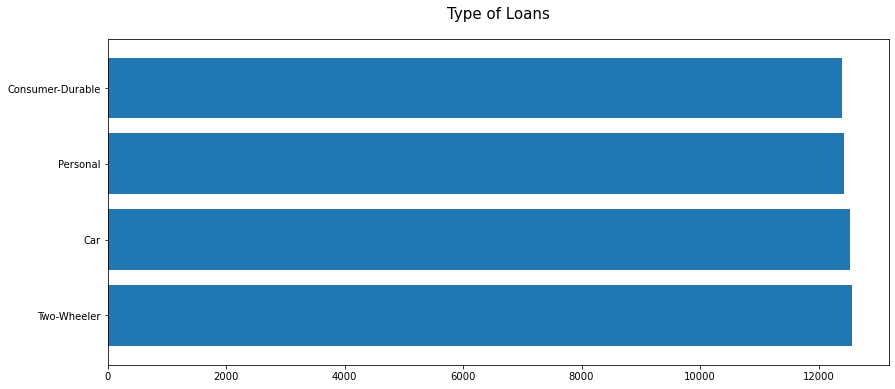

In [95]:
# Univariate Analysis
plt.figure(figsize = [14,6])
df["loan_type"].value_counts().plot.barh(width = .8)
plt.title("Type of Loans", fontdict={"fontsize":15}, pad =20)
plt.show()

**We can see even distribution of data among four types of loans given.**

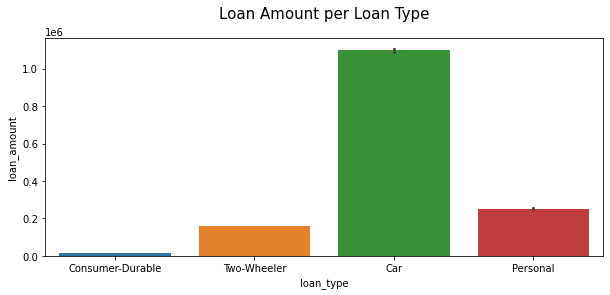

In [96]:
# Loan Amount Vs Loan Type
plt.figure(figsize=[10,4])
sns.barplot(df['loan_type'],df['loan_amount'])
plt.title("Loan Amount per Loan Type", fontdict={"fontsize":15}, pad =20)
plt.show()

1. Loan amount for Car is higher amongst all. 
2. Loan amount for Consumer-durable is small.

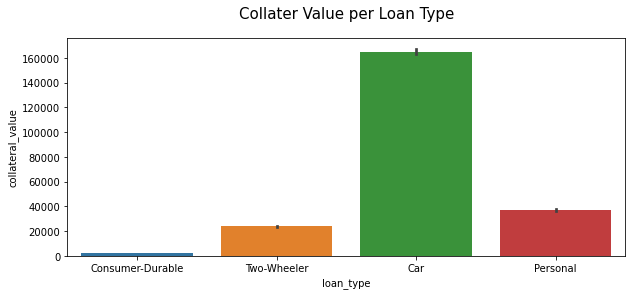

In [97]:
# Loan amount Vs Collateral Value
plt.figure(figsize=[10,4])
sns.barplot(df['loan_type'],df['collateral_value'])
plt.title("Collater Value per Loan Type", fontdict={"fontsize":15}, pad =20)
plt.show()

1. Collateral value of car loan is highest among all loan types. 
2. Collaterval value vs loan type follows same distribution like above plot. 

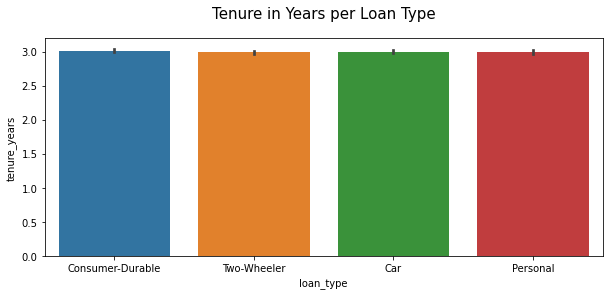

In [98]:
# Loan type vs tenure_years
plt.figure(figsize=[10,4])
sns.barplot(df['loan_type'],df['tenure_years'])
plt.title("Tenure in Years per Loan Type", fontdict={"fontsize":15}, pad =20)
plt.show()

Minimum and maximum tenure years for all loan types are same. Maximum tenure is 3 years. 

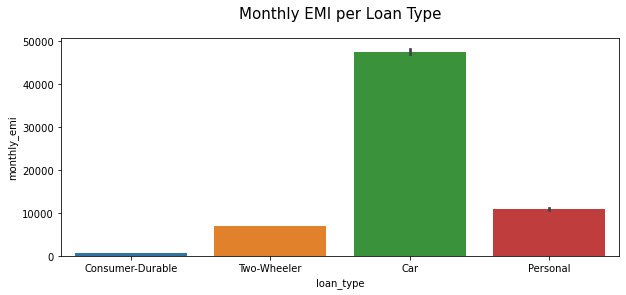

In [99]:
# Loan type vs Monthly EMI
plt.figure(figsize=[10,4])
sns.barplot(df['loan_type'],df['monthly_emi'])
plt.title("Monthly EMI per Loan Type", fontdict={"fontsize":15}, pad =20)
plt.show()

1. Monthly EMI for car loan is highest among all. 
2. Monthly EMI for Consumer-Durable is small among all.

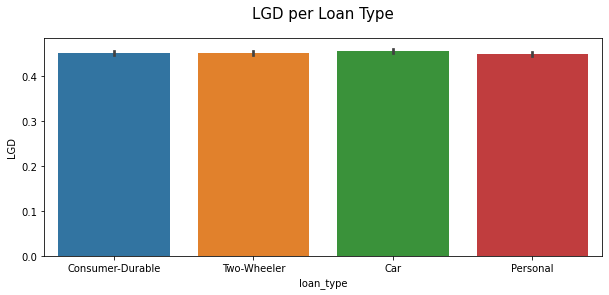

In [100]:
# Loan Type vs LGD
plt.figure(figsize=[10,4])
sns.barplot(df['loan_type'],df['LGD'])
plt.title("LGD per Loan Type", fontdict={"fontsize":15}, pad =20)
plt.show()

LGD for Car loan is higher compared to other categories.

## Univariate Analysis for Numerical Feature

In [101]:
# Defining function for box and distplot for all numerical variables to check data distribution
def Uni_Analysis_Numarical(dataframe, column):
    sns.set(style='darkgrid')
    plt.figure(figsize=(25, 5))
    
    plt.subplot(1, 3, 1)
    sns.boxplot(data=dataframe, x=column, orient='v').set(title='Box Plot')
    
    plt.subplot(1, 3, 2)
    sns.distplot(dataframe[column].dropna()).set(title='Distplot')
    plt.show()

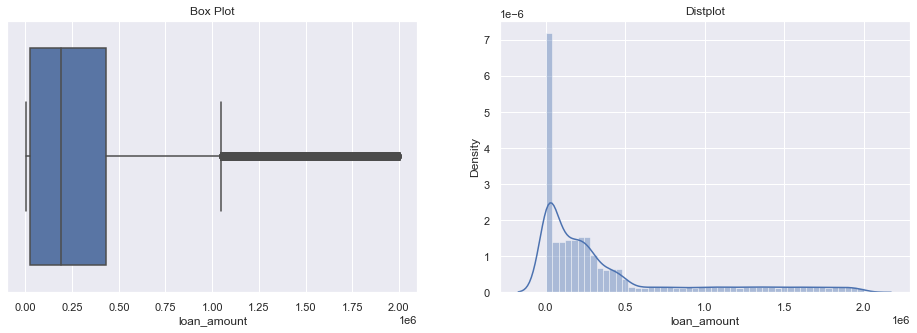

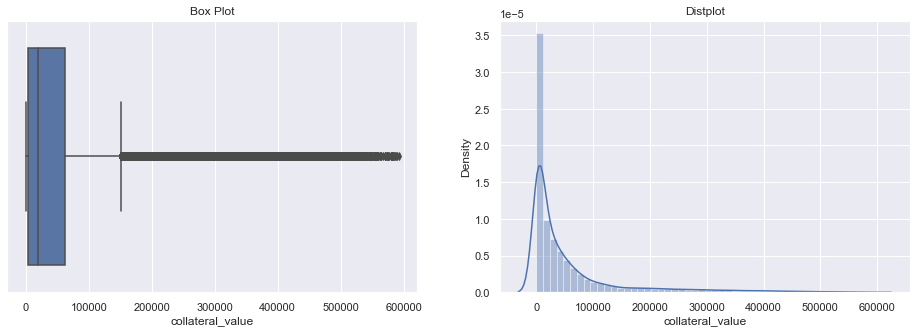

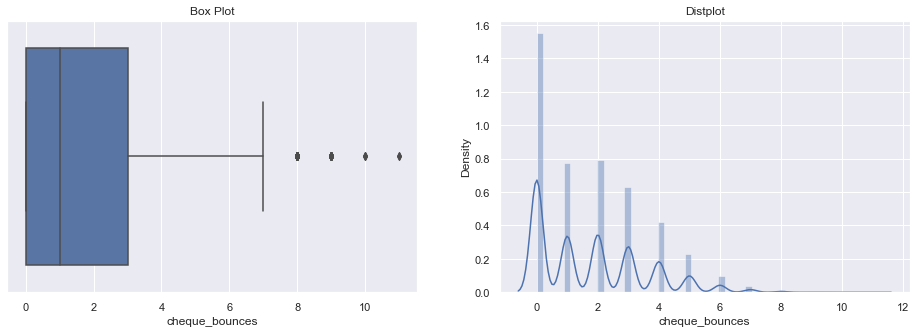

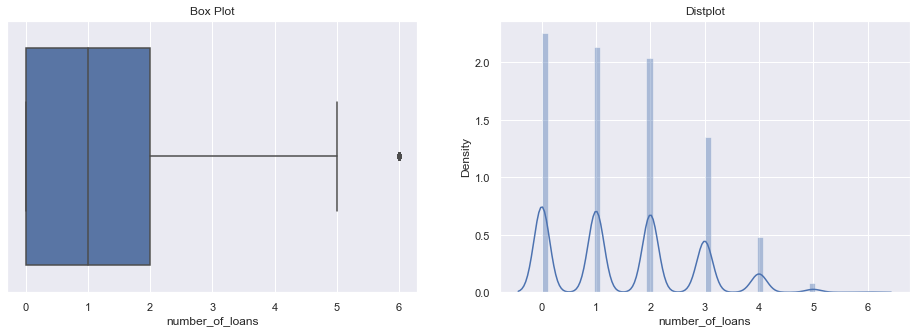

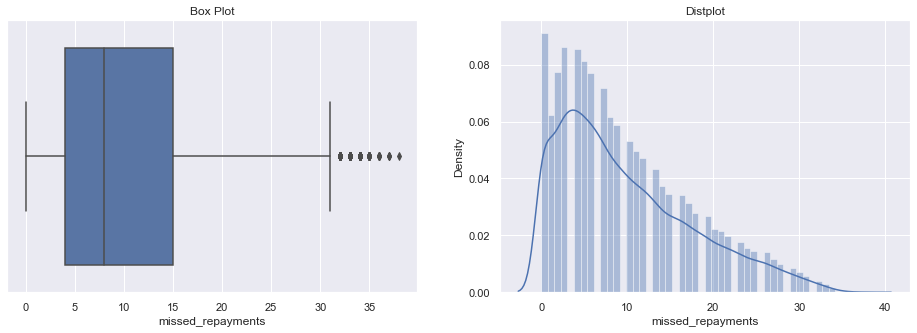

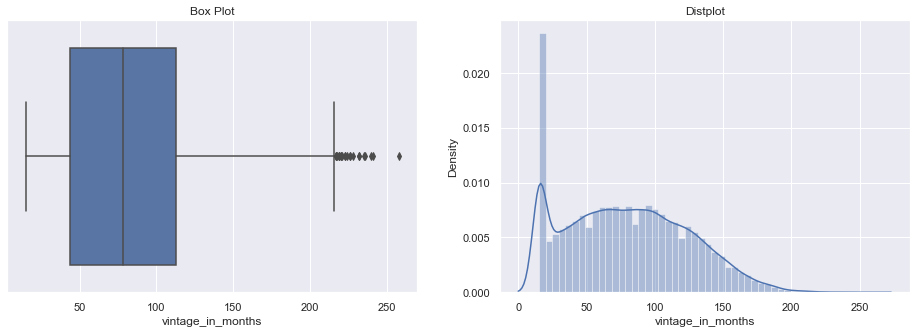

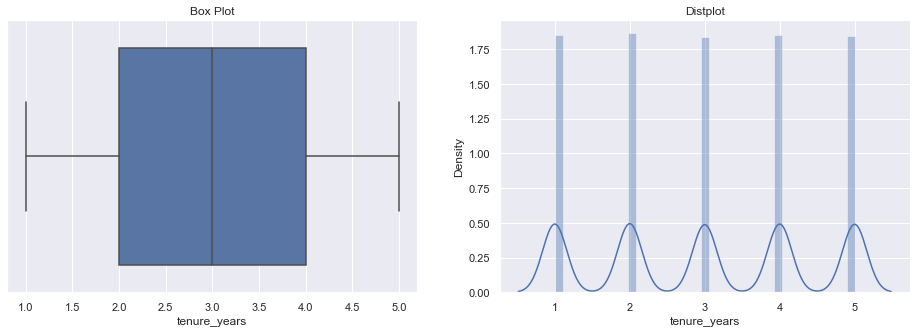

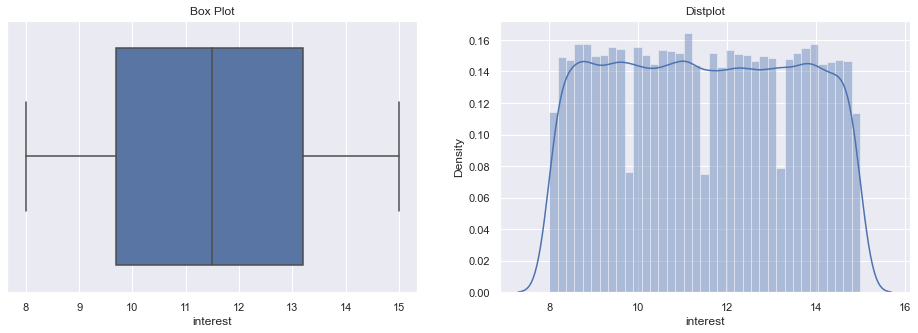

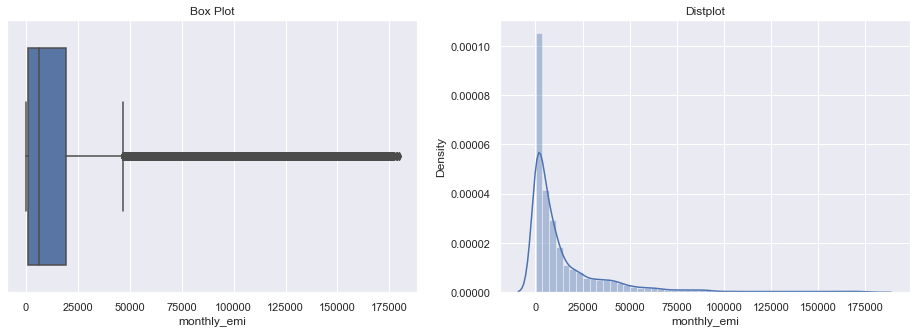

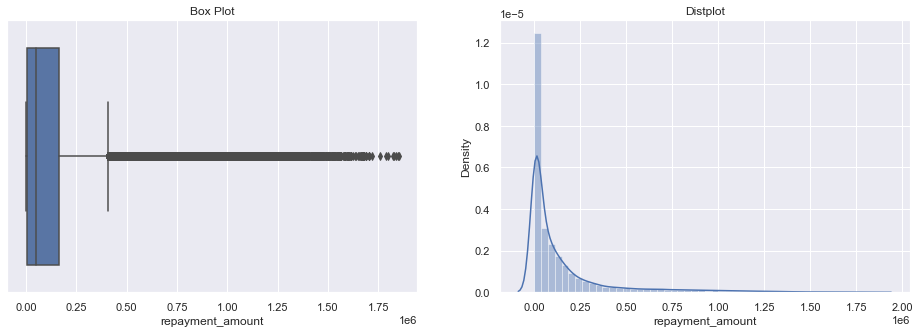

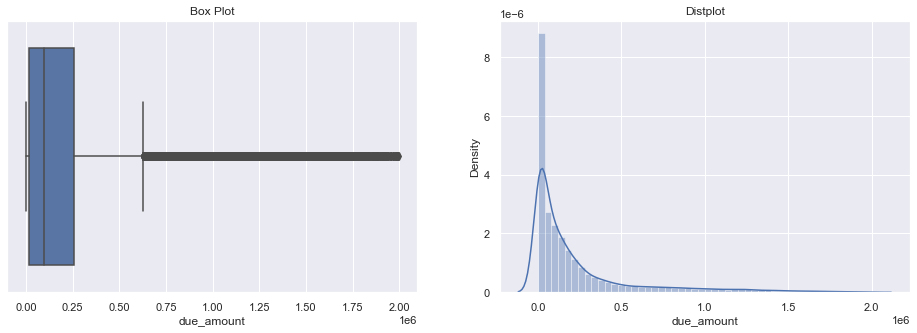

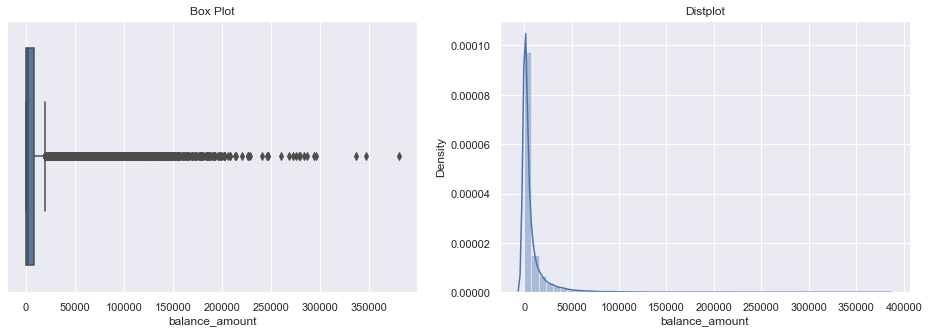

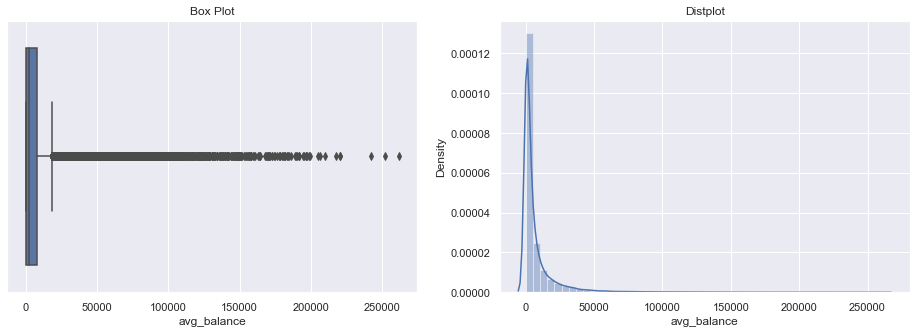

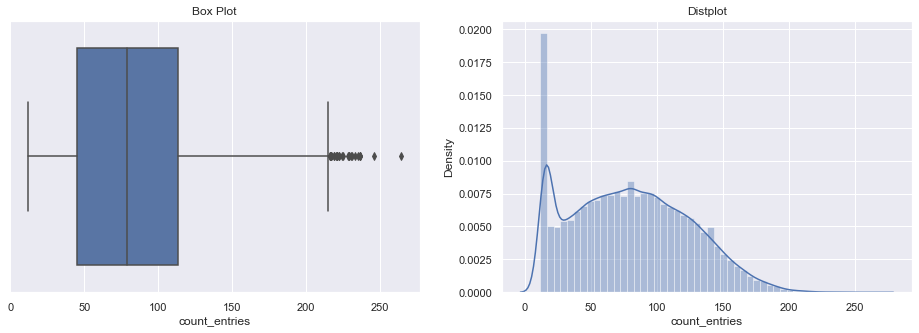

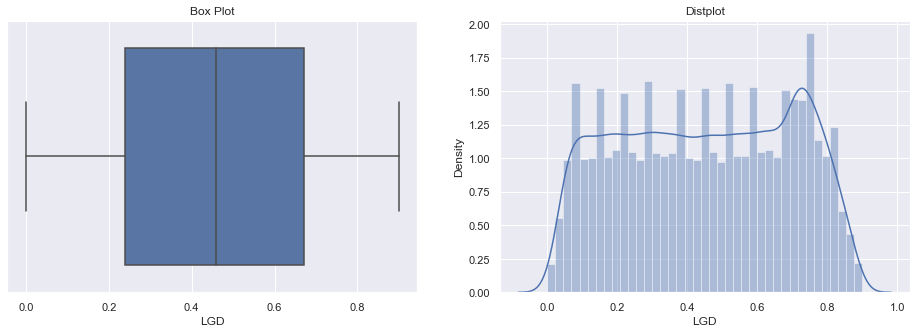

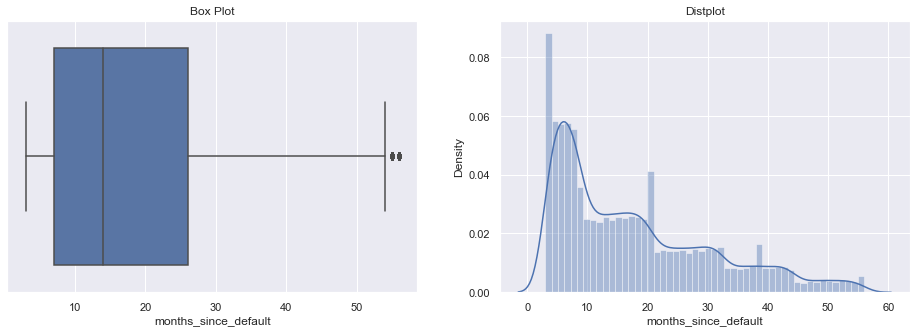

In [102]:
for i in numeric_features:
    Uni_Analysis_Numarical(df,i)

In [103]:
# Segregating datasets into numerical and categorical datasets
numeric_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(exclude=[np.number])

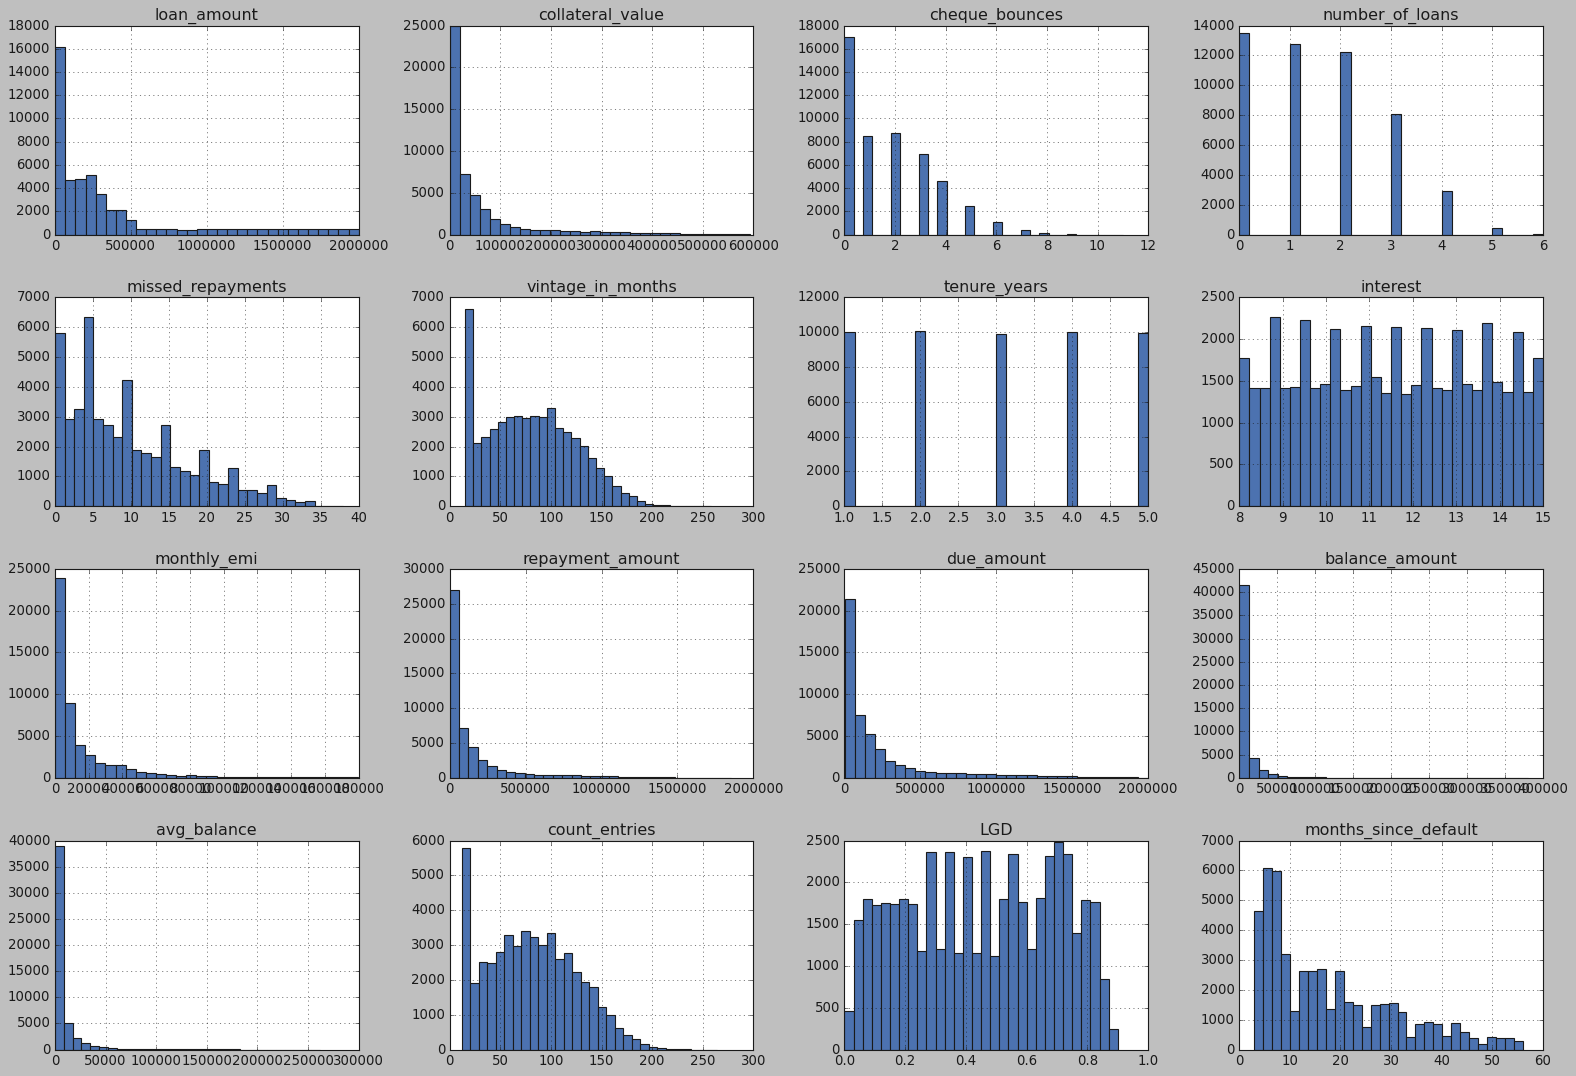

In [104]:
#plt.figure(figsize = (24,24))
plt.style.use('classic')
df[numeric_data.columns].hist(bins=30, figsize = (24,16))
plt.show()

**Observations:**
1. Loan amount, Collateral value, chaque_bounces, number of loans, missed repayments, vintage in months, monthly EMI, repayment_amount, due_amount, balance amount, avg_balance and months since default show right-skewed distribution.
2. LGD seems normally distributed.
3. Interest rate is normally distributed.
4. Collateral value and loan_amount have significant number of outliers.

# Feature Transformation for Main Dataset 

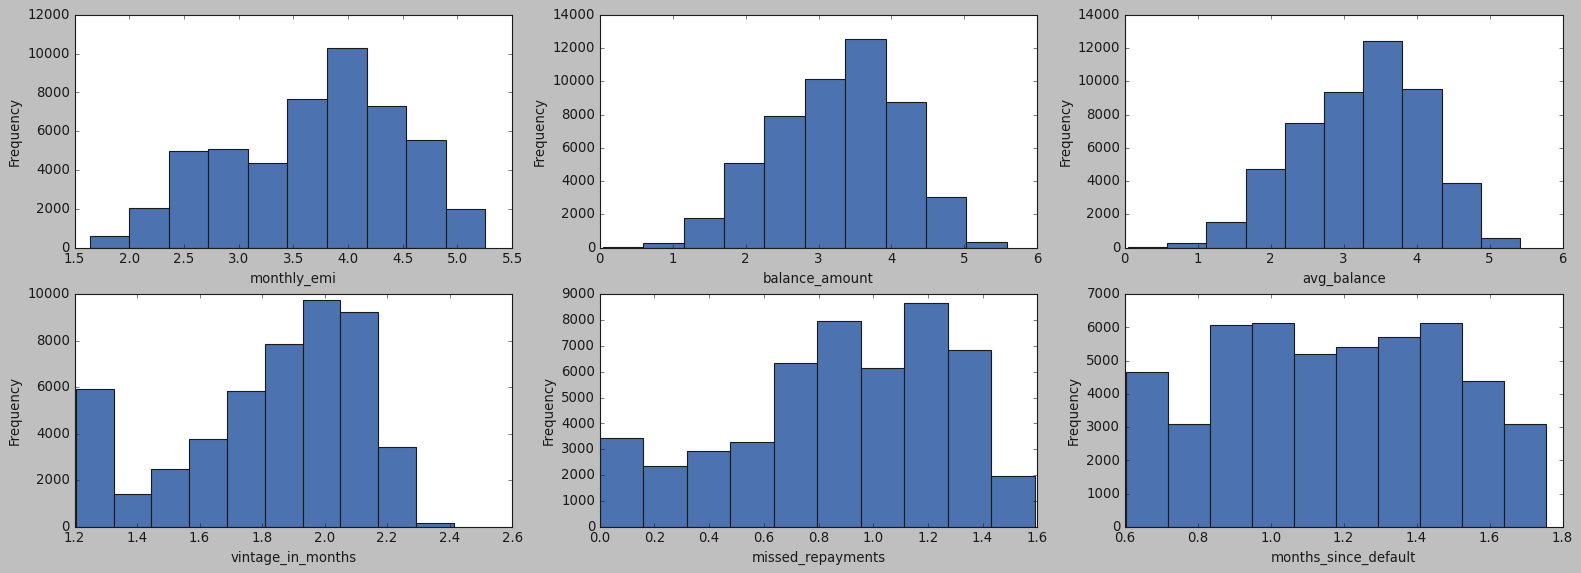

In [105]:
# Log transformation for right skewed variables
log_var = [ "monthly_emi","balance_amount", "avg_balance", 
           'vintage_in_months', "missed_repayments", "months_since_default"]

fig = plt.figure(figsize=(24,8))

for j in range(len(log_var)):
    var = log_var[j]
    transformed = var
    df[transformed]=np.log10(df[var]+1)

    sub = fig.add_subplot(2, 3, j + 1)
    sub.set_xlabel(var)
    df[transformed].plot(kind = 'hist')

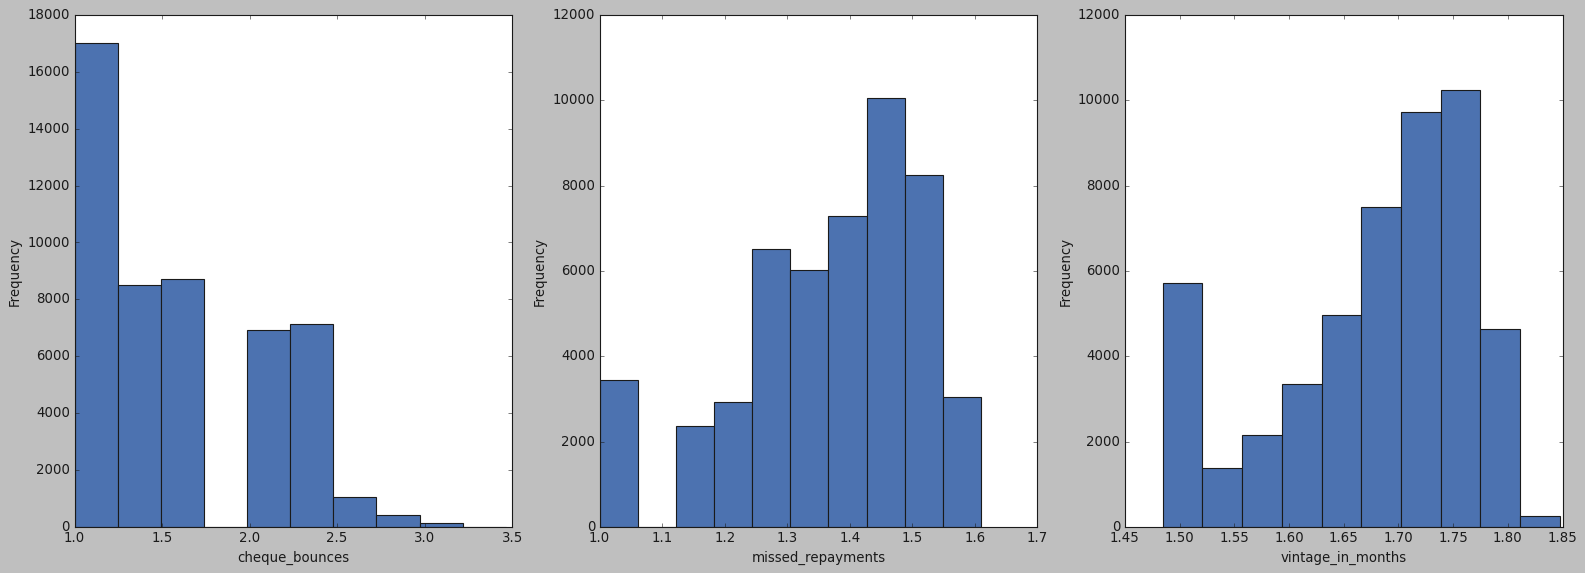

In [106]:
# Applying Sqaure root Power transformation for rest of the variables
sqrt_var = ['cheque_bounces','missed_repayments','vintage_in_months']
fig = plt.figure(figsize=(24,8))

for i in range(len(sqrt_var)):
    var = sqrt_var[i]
    sqrt_transformed = var
    df[sqrt_transformed]=np.sqrt(df[var]+1)
    
    sub = fig.add_subplot(1, 3, i + 1)
    sub.set_xlabel(var)
    df[sqrt_transformed].plot(kind = 'hist')

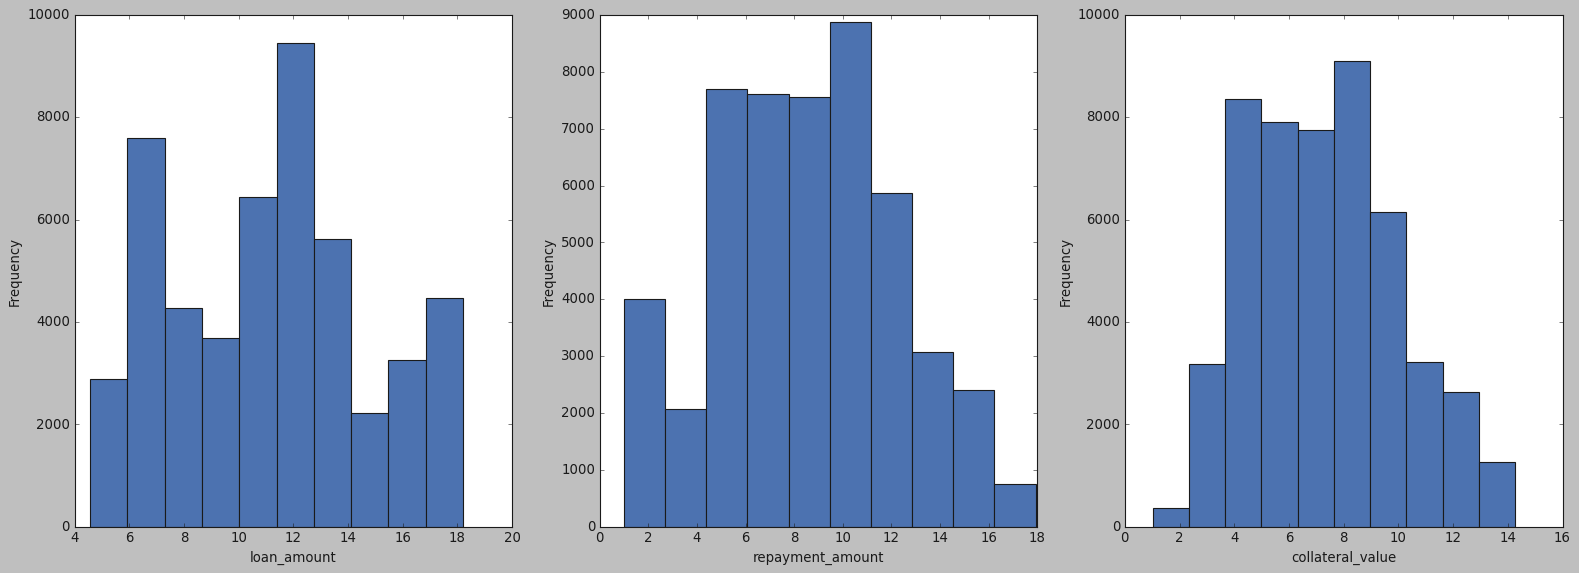

In [107]:
# Applying power transformation using fifth root
f_var = ['loan_amount','repayment_amount','collateral_value']
fig = plt.figure(figsize=(24,8))

for k in range(len(f_var)):
    var = f_var[k]
    f_transformed = var
    df[f_transformed]=((df[var]+1)**(1/5))
    
    sub = fig.add_subplot(1, 3, k + 1)
    sub.set_xlabel(var)
    df[f_transformed].plot(kind = 'hist')

# Univariate Analysis for numerical Features (Test Data)

In [108]:
# Segregating datasets into numerical and categorical datasets
test_numeric_data = test_df.select_dtypes(include=[np.number])
test_categorical_data = test_df.select_dtypes(exclude=[np.number])

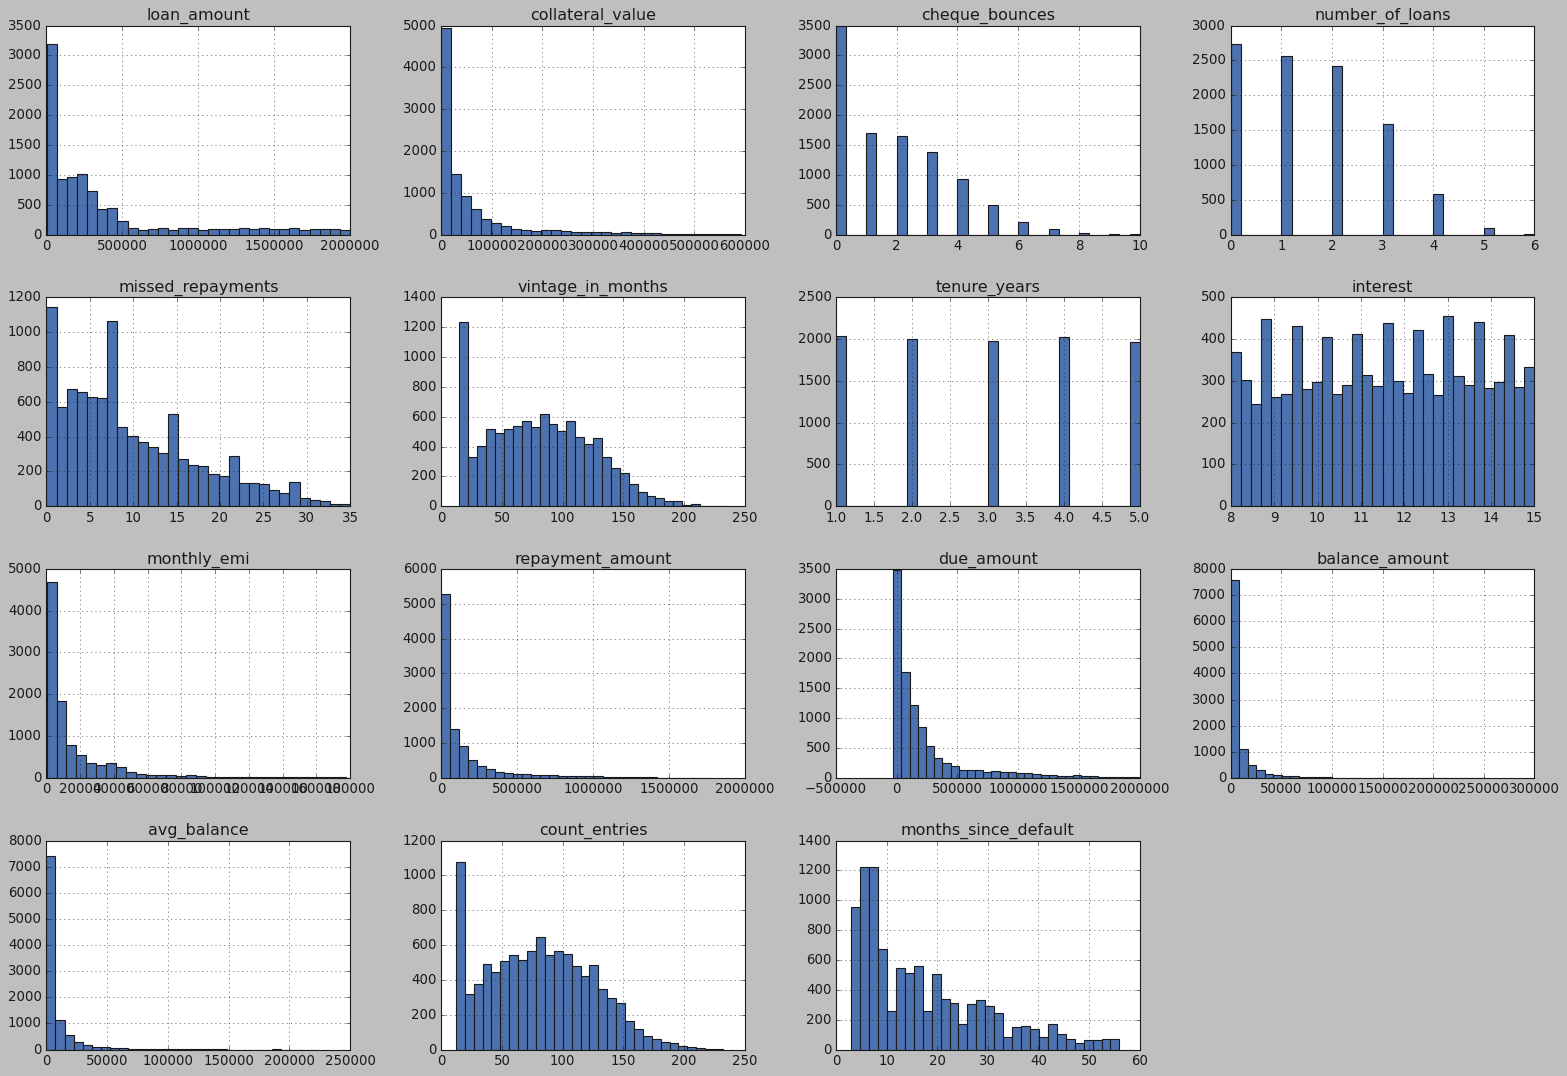

In [109]:
#plt.figure(figsize = (24,24))
plt.style.use('classic')
test_df[test_numeric_data.columns].hist(bins=30, figsize = (24,16))
plt.show()

**Observations:**
1. Loan amount, Collateral value, chaque_bounces, number of loans, missed repayments, vintage in months, monthly EMI, repayment_amount, due_amount, balance amount, avg_balance and months since default show right-skewed distribution.
2. LGD seems normally distributed.
3. Interest rate is normally distributed.
4. Collateral value and loan_amount have significant number of outliers.

# Feature Transformation for Test Dataset

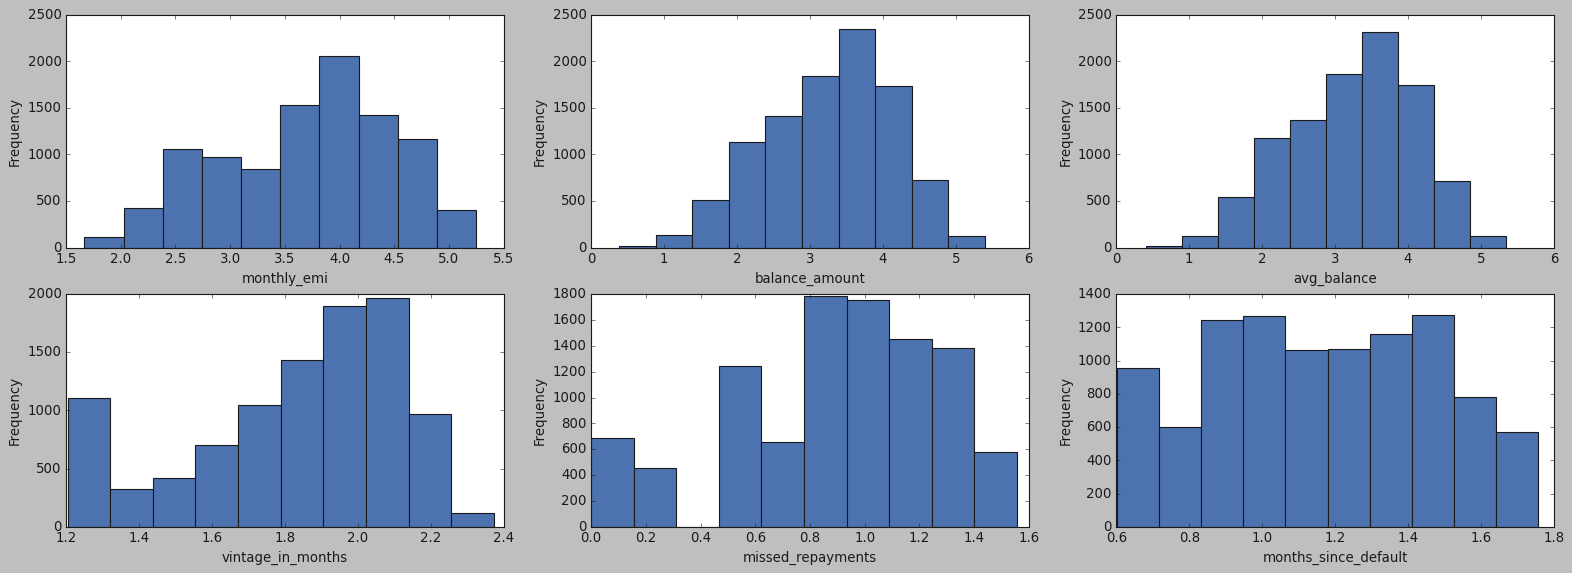

In [110]:
# Log transformation for right skewed variables
log_var = [ "monthly_emi","balance_amount", "avg_balance", 
           'vintage_in_months', "missed_repayments", "months_since_default"]

fig = plt.figure(figsize=(24,8))

for j in range(len(log_var)):
    var = log_var[j]
    transformed = var
    test_df[transformed]=np.log10(test_df[var]+1)

    sub = fig.add_subplot(2, 3, j + 1)
    sub.set_xlabel(var)
    test_df[transformed].plot(kind = 'hist')

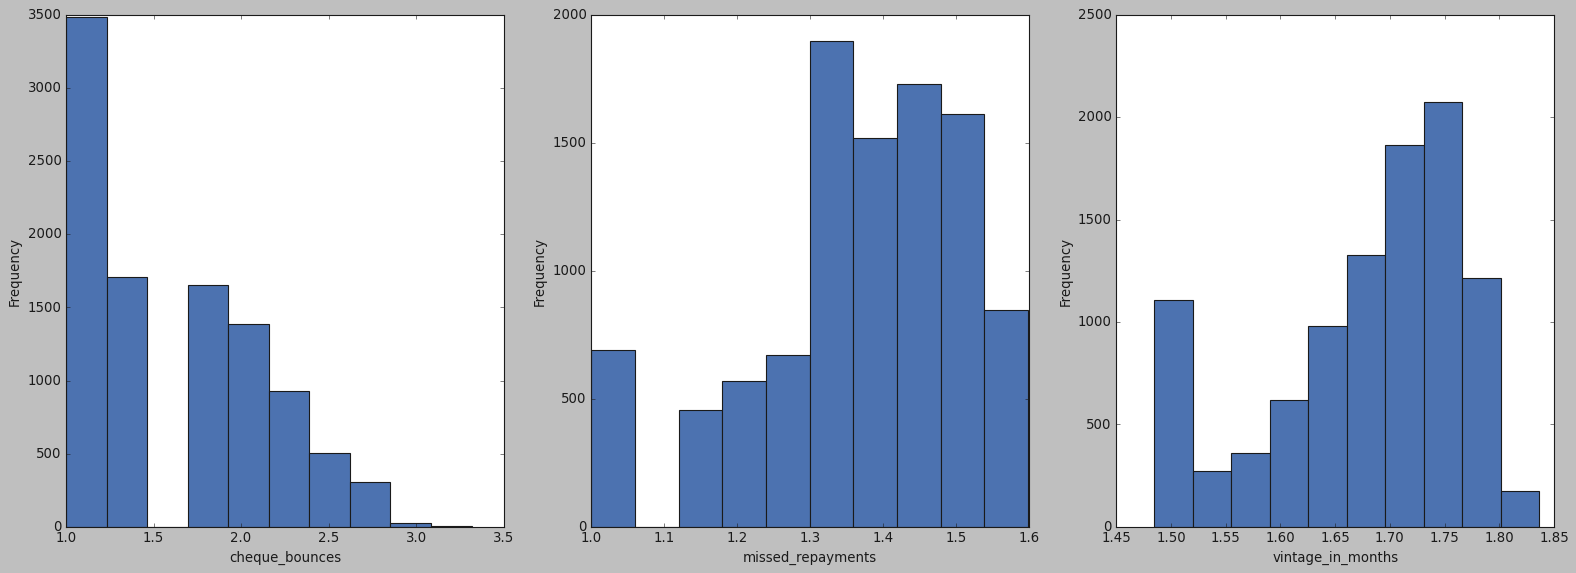

In [111]:
# Applying Sqaure root Power transformation for rest of the variables
sqrt_var = ['cheque_bounces','missed_repayments','vintage_in_months']
fig = plt.figure(figsize=(24,8))

for i in range(len(sqrt_var)):
    var = sqrt_var[i]
    sqrt_transformed = var
    test_df[sqrt_transformed]=np.sqrt(test_df[var]+1)
    
    sub = fig.add_subplot(1, 3, i + 1)
    sub.set_xlabel(var)
    test_df[sqrt_transformed].plot(kind = 'hist')

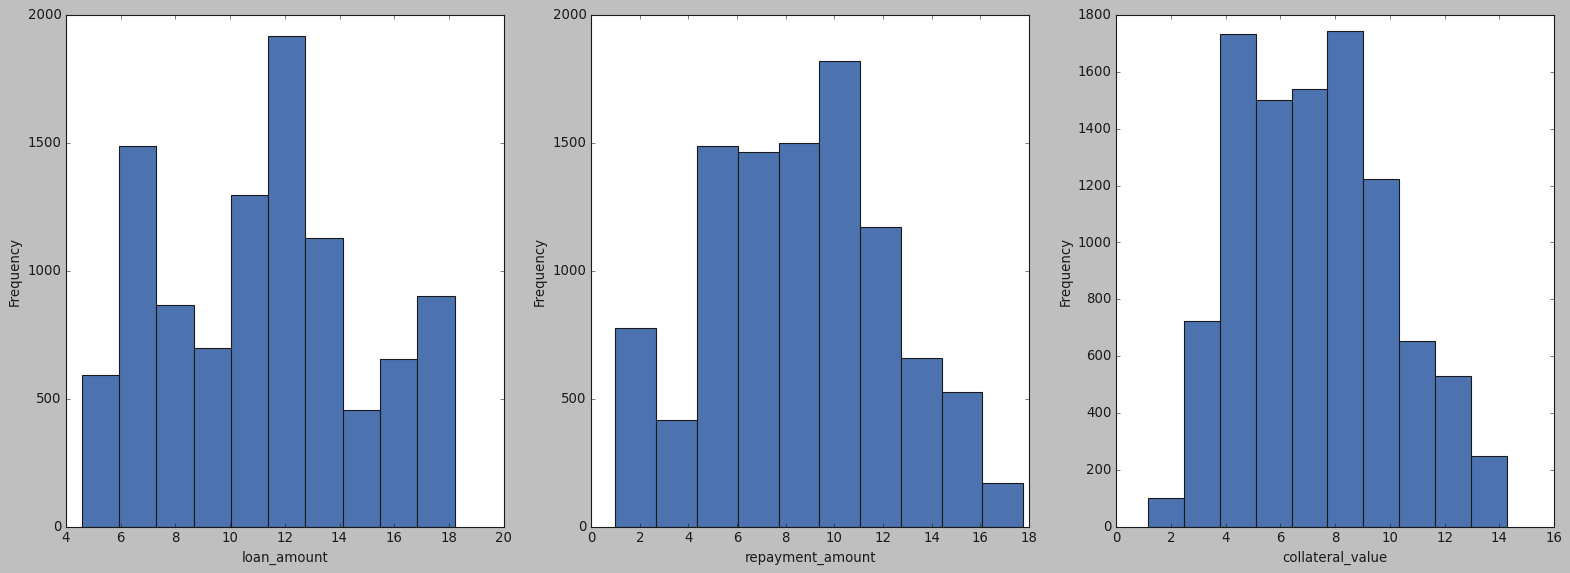

In [112]:
# Applying power transformation using fifth root
f_var = ['loan_amount','repayment_amount','collateral_value']
fig = plt.figure(figsize=(24,8))

for k in range(len(f_var)):
    var = f_var[k]
    f_transformed = var
    test_df[f_transformed]=((test_df[var]+1)**(1/5))
    
    sub = fig.add_subplot(1, 3, k + 1)
    sub.set_xlabel(var)
    test_df[f_transformed].plot(kind = 'hist')

## Bivariate Analysis

Text(0.5, 1.0, 'Repayment Amount Vs Loan Amount')

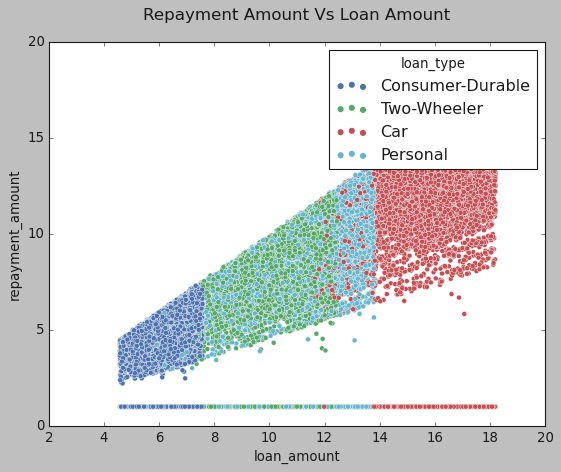

In [113]:
sns.scatterplot(x=df.loan_amount, y = df.repayment_amount, data=df,hue = 'loan_type')
plt.title("Repayment Amount Vs Loan Amount", fontdict={"fontsize":15}, pad =20)

This plot shows that the loan amount is directly proportional with repayment amount.

Text(0.5, 1.0, 'LGD Vs Loan Amount')

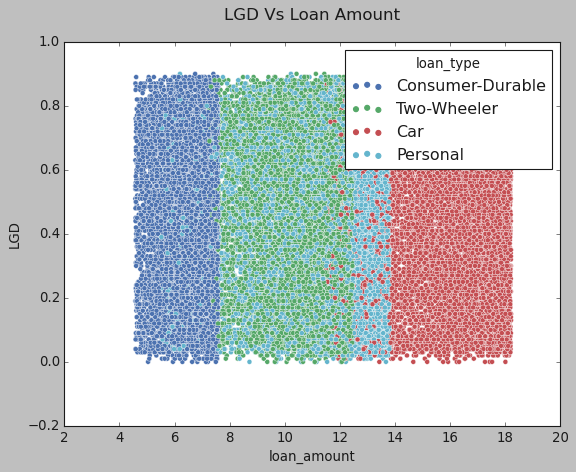

In [114]:
sns.scatterplot(x=df.loan_amount, y = df.LGD, data=df,hue = 'loan_type')
plt.title("LGD Vs Loan Amount", fontdict={"fontsize":15}, pad =20)

**Observation**

Text(0.5, 1.0, 'LGD Vs Months since default')

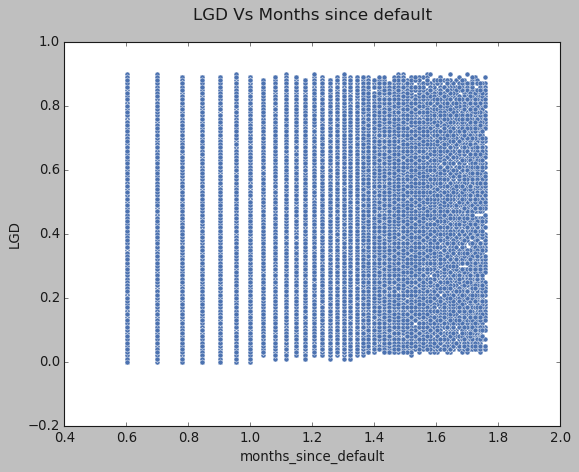

In [115]:
sns.scatterplot(x=df.months_since_default, y = df.LGD, data=df)
plt.title("LGD Vs Months since default", fontdict={"fontsize":15}, pad =20)

### Multi-variate Analysis

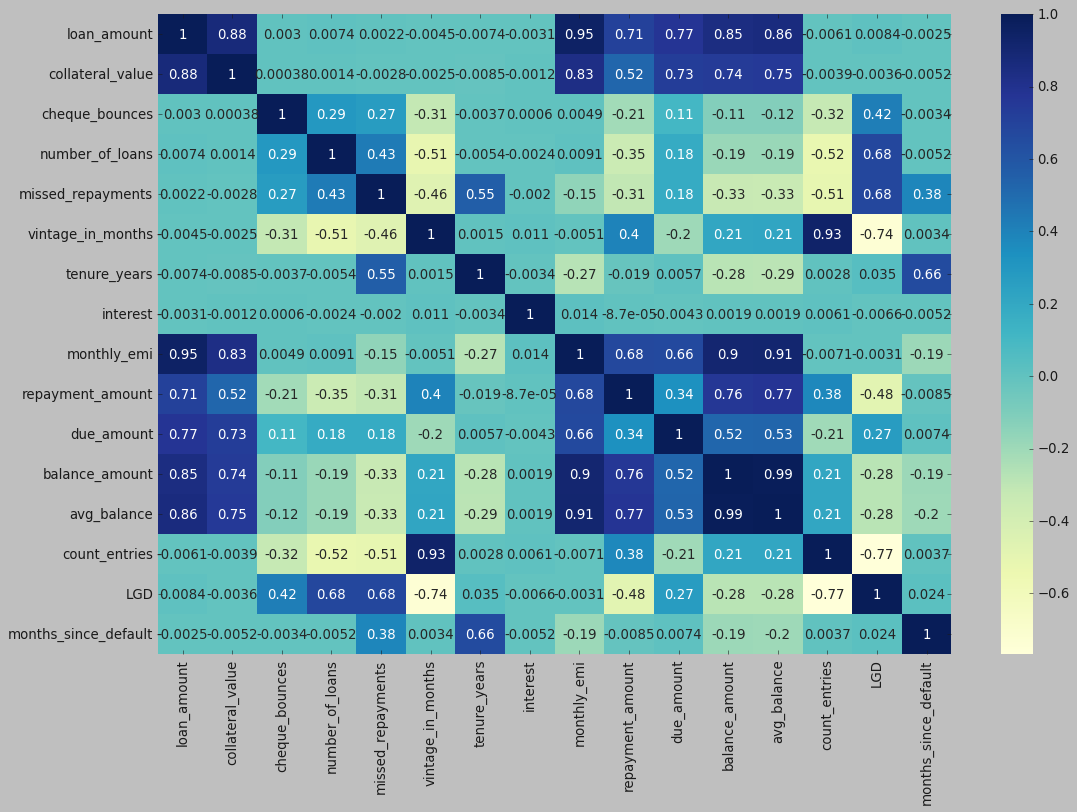

In [116]:
# Let's check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

**Observation:**
1. LGD is highly positively correlated with number_of_loans and missed_repayments.
2. LGD is highly negatively correlated with vintage_in_months and count_entries

### One-hot encoding for Categorical Variable (Main Data)

In [119]:
dummy = pd.get_dummies(df['loan_type'],drop_first=True)
#adding results to original dataset
df = pd.concat([df,dummy],axis=1)

In [120]:
df.head()

,loan_acc_num,loan_type,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,...,repayment_amount,due_amount,balance_amount,avg_balance,count_entries,LGD,months_since_default,Consumer-Durable,Personal,Two-Wheeler
0,LN79307711,Consumer-Durable,7.381697,5.477440,2.000000,0,1.265725,1.762728,2,10.1,...,6.707163,8343.42,2.893012,2.768275,125.0,0.16,1.230449,1,0,0
1,LN88987787,Two-Wheeler,10.391776,6.341491,1.414214,0,1.000000,1.787708,2,11.8,...,9.923738,24940.39,3.907422,3.868235,163.0,0.12,1.230449,0,0,1
2,LN78096023,Car,13.725001,10.304571,1.000000,1,1.428773,1.536791,3,14.6,...,9.417719,412952.27,4.011216,3.892867,23.0,0.61,0.602060,0,0,0
3,LN56862431,Two-Wheeler,8.778309,6.348346,2.449490,2,1.414214,1.578405,2,9.6,...,1.000000,52125.00,2.787836,2.715234,27.0,0.80,0.903090,0,0,1
4,LN77262680,Consumer-Durable,6.127207,4.021831,1.000000,1,1.265725,1.673123,2,9.6,...,5.369518,4172.49,2.606252,2.511456,63.0,0.36,1.176091,1,0,0


### One-hot encoding for Categorical Variable (Test Data)

In [121]:
test_dummy = pd.get_dummies(test_df['loan_type'],drop_first=True)
#adding results to original dataset
test_df = pd.concat([test_df,test_dummy],axis=1)

In [122]:
test_df = test_df.drop(columns = ['loan_type','loan_acc_num','customer_name','customer_address','date','disbursal_date','default_date'],axis=1)
test_df.head()

,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,repayment_amount,due_amount,balance_amount,avg_balance,count_entries,months_since_default,Consumer-Durable,Personal,Two-Wheeler
0,16.596232,6.332759,2.000000,1,1.333473,1.736961,1,12.1,5.048931,14.654520,583200.95,4.518859,4.424254,100.0,0.778151,0,0,0
1,7.369193,4.708478,1.000000,3,1.559283,1.613090,5,12.2,2.687163,4.665140,19522.35,1.941313,1.912275,40.0,1.591065,1,0,0
2,11.573667,6.080190,1.414214,2,1.000000,1.675166,1,13.9,4.270362,10.225837,95847.48,4.283132,4.190395,64.0,0.954243,0,0,0
3,11.411670,7.663551,2.236068,3,1.453941,1.484628,2,12.5,3.961720,7.121069,175217.42,3.522499,3.448354,14.0,1.204120,0,0,1
4,5.693178,4.396525,1.414214,1,1.000000,1.784570,1,14.6,2.732088,5.093892,2551.36,2.810105,2.828673,149.0,0.903090,1,0,0


As the data cleaning part and EDA is done we can now drop the unnecessary variables for model building such as loan_acc_num and loan_type.

In [123]:
# Dropping unneccesary columns of main dataset
df = df.drop(columns=['loan_acc_num','loan_type'])

In [124]:
df.head()

,loan_amount,collateral_value,cheque_bounces,number_of_loans,missed_repayments,vintage_in_months,tenure_years,interest,monthly_emi,repayment_amount,due_amount,balance_amount,avg_balance,count_entries,LGD,months_since_default,Consumer-Durable,Personal,Two-Wheeler
0,7.381697,5.477440,2.000000,0,1.265725,1.762728,2,10.1,3.005747,6.707163,8343.42,2.893012,2.768275,125.0,0.16,1.230449,1,0,0
1,10.391776,6.341491,1.414214,0,1.000000,1.787708,2,11.8,3.755436,9.923738,24940.39,3.907422,3.868235,163.0,0.12,1.230449,0,0,1
2,13.725001,10.304571,1.000000,1,1.428773,1.536791,3,14.6,4.225025,9.417719,412952.27,4.011216,3.892867,23.0,0.61,0.602060,0,0,0
3,8.778309,6.348346,2.449490,2,1.414214,1.578405,2,9.6,3.379612,1.000000,52125.00,2.787836,2.715234,27.0,0.80,0.903090,0,0,1
4,6.127207,4.021831,1.000000,1,1.265725,1.673123,2,9.6,2.599741,5.369518,4172.49,2.606252,2.511456,63.0,0.36,1.176091,1,0,0


# Model Building

In [125]:
# Importing necessary libraries
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [126]:
# Deviding dataset into X and Y for model building
y = df.pop('LGD')
X = df

In [127]:
# Splitting data into train and test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [128]:
# Using standardscaler for
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Using Recurrsive Feature Elimination

In [129]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [130]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, n_features_to_select=10) 
rfe = rfe.fit(X_train, y_train)

In [131]:
from sklearn.linear_model import *
from  sklearn import metrics
#Rsquared on test set
y_pred_lr = rfe.predict(X_test)
metrics.r2_score(y_test, y_pred_lr)

0.8635119686722795

### Using Multiple Linear Regression

In [132]:
# Representing LinearRegression as lr(Creating LinearRegression Object)
lm = LinearRegression()

lm.fit(X_train, y_train)
#Rsquared on test set
y_pred_lr = lm.predict(X_test)
metrics.r2_score(y_test, y_pred_lr)

0.8638126748386825

### Using Random Forest Regressor

In [133]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(bootstrap= True,n_estimators = 200, random_state = 42, 
                                     max_depth=4, max_features=None, min_samples_leaf= 2, min_samples_split= 4)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, max_features=None, min_samples_leaf=2,
                      min_samples_split=4, n_estimators=200, random_state=42)

In [134]:
y_pred_train = rf_regressor.predict(X_train)
print(r2_score(y_train, y_pred_train))

0.7706590576051324


In [135]:
y_pred_test = rf_regressor.predict(X_test)
print(r2_score(y_test, y_pred_test))

0.7667357862534443


### Using Gradient Boosting Regression

In [136]:
from sklearn.ensemble import GradientBoostingRegressor
# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 500,
              'max_depth': 4,
              'min_samples_split': 4,
              'learning_rate': 0.01,
              'loss': 'ls'}

# Create an instance of gradient boosting regressor

gbr = GradientBoostingRegressor(**gbr_params)

# Fit the model

gbr.fit(X_train, y_train)

y_pred=gbr.predict(X_test)

# Print Coefficient of determination R^2

print("R squared: %.3f" % gbr.score(X_test, y_test))

R squared: 0.916


In [137]:
from sklearn.metrics import r2_score
y_pred_train=gbr.predict(X_train)

# Print Coefficient of determination R^2
print("R_squared in train set: ",r2_score(y_train, y_pred_train))

R_squared in train set:  0.9216888502292602


In [138]:
y_pred_test=gbr.predict(X_test)
#
# Print Coefficient of determination R^2
print("R_squared in test set: ",r2_score(y_test, y_pred_test))

R_squared in test set:  0.9164668312748503


[0.00000000e+00 7.87627603e-03 6.81935047e-03 9.73691133e-02
 2.10537973e-01 5.23014012e-01 5.45342701e-02 0.00000000e+00
 1.72947072e-03 5.05179841e-02 4.24293496e-02 2.15078085e-05
 2.94135839e-04 4.85655783e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


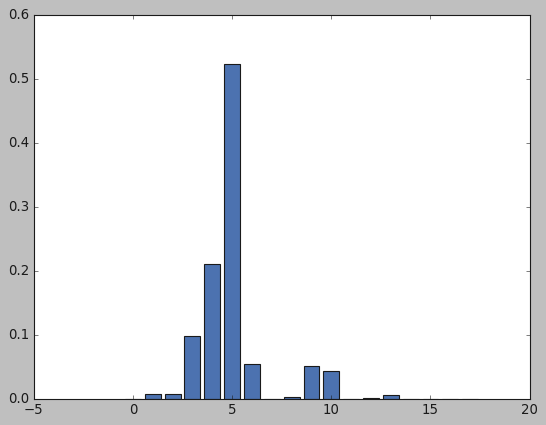

In [139]:
# plot feature importance
# feature importance
print(gbr.feature_importances_)
# plot
plt.bar(range(len(gbr.feature_importances_)), gbr.feature_importances_)
plt.show()

<AxesSubplot:>

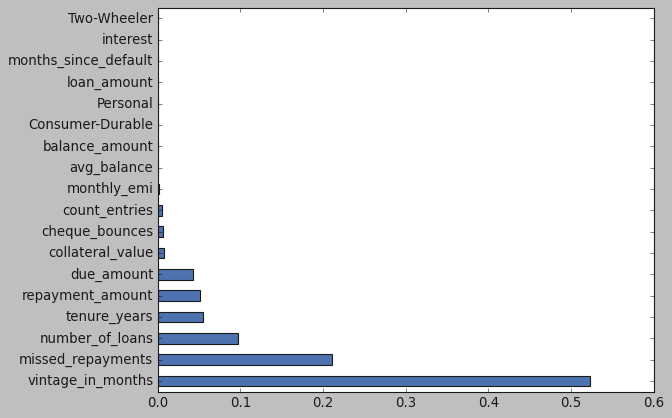

In [140]:
feat_importances = pd.Series(gbr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

According to Gradient Boosting Regressor the important features are:
1) vintage_in_months - No of months for which borrower is connected with bank
2) missed_repayments -  no of instalments missed by borrower
3) no_of_loans - no of other loans customer has
4) tenure_years - tenure of loan repayment in years
5) repayment_amount - total amount repaid by borrower
6) chaque_bounces - no of cheques bounced
7) collateral value 
8) loan_amount 
9) monthly_EMI

### Using XGBoost Regression

In [141]:
!pip install xgboost 

In [142]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

In [143]:
# defining model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('R_squared: %.3f (%.3f)' % (scores.mean(), scores.std()) )

R_squared: 0.985 (0.001)


In [144]:
from xgboost import XGBRegressor
# define model
RegModel=XGBRegressor(max_depth=5, learning_rate=0.015, n_estimators=1000, objective='reg:linear', booster='gbtree')

In [145]:
XGB=RegModel.fit(X_train,y_train)
prediction=XGB.predict(X_train)
print("train score: ", r2_score(y_train, prediction))
y_pred_test=XGB.predict(X_test)
print("test score: ", r2_score(y_test, y_pred_test))

[21:20:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
train score:  0.9797930842081563
test score:  0.9726946084363222


### Fine tuning XGBoost Regressor

In [146]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
# define the model with best resulted parameters
RegModel=XGBRegressor(colsample_bytree= 0.7, max_depth=3, learning_rate=0.5, n_estimators=1000, objective='reg:linear', booster='gbtree')
xgbr = xgb.XGBRegressor(seed = 20)
XGB=RegModel.fit(X_train,y_train)
prediction=XGB.predict(X_train)
print("train score: ", r2_score(y_train, prediction))
y_pred_test=XGB.predict(X_test)
print("test score: ", r2_score(y_test, y_pred_test))

[21:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
train score:  0.9979174969132418
test score:  0.9956226838871167


# Prediction on Unseen Test Data

In [147]:
df.columns

Index(['loan_amount', 'collateral_value', 'cheque_bounces', 'number_of_loans',
       'missed_repayments', 'vintage_in_months', 'tenure_years', 'interest',
       'monthly_emi', 'repayment_amount', 'due_amount', 'balance_amount',
       'avg_balance', 'count_entries', 'months_since_default',
       'Consumer-Durable', 'Personal', 'Two-Wheeler'],
      dtype='object')

In [148]:
test_df.columns

Index(['loan_amount', 'collateral_value', 'cheque_bounces', 'number_of_loans',
       'missed_repayments', 'vintage_in_months', 'tenure_years', 'interest',
       'monthly_emi', 'repayment_amount', 'due_amount', 'balance_amount',
       'avg_balance', 'count_entries', 'months_since_default',
       'Consumer-Durable', 'Personal', 'Two-Wheeler'],
      dtype='object')

In [149]:
test_df.shape

(9997, 18)

In [150]:
unseen = sc.fit_transform(test_df)

In [151]:
test_df = pd.DataFrame(test_df)

In [152]:
#Making predictions
final_predictions = XGB.predict(test_df)
final_prediction_series = pd.Series(final_predictions)

In [153]:
# Combining the results into dataframe
submission_df = pd.DataFrame({'id':test['loan_acc_num'].values, 'LGD':final_prediction_series.values})

In [156]:
submission_df.sample(10)

,id,LGD
3272,LN31358060,0.310484
5220,LN94306990,0.296898
4932,LN76701745,0.270514
8580,LN49389714,0.520584
7481,LN45707317,0.268187
966,LN74909191,0.258608
4197,LN10301267,0.292879
8604,LN41351345,0.526794
848,LN91406580,0.520379
4494,LN60592013,0.252267


In [157]:
submission_df.to_csv("C:/Users/Yash/Desktop/Data Science/Course 5/BFSI_case_study/predicted_LGD.csv",index=False)